# 0.0) Import das Bibliotecas

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats as ss
from IPython.display import Image
from datetime import datetime, timedelta

### 0.1) Funções Auxiliares

In [88]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame({ 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0])

def format_col_name(col):
    list_str = re.findall('[A-Z][^A-Z]*', col)

    return '_'.join(list_str).lower()

def plot_2_var_corr(df, col1, col2):
    x = sns.heatmap( df[[col1, col2]].corr( method='pearson' ), annot=True );
    #bottom, top = x.get_ylim()
    #x.set_ylim( bottom+0.5, top-0.5 );
    
    return x

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline

    warnings.filterwarnings('ignore')
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', 100)
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set_theme()

In [79]:
jupyter_settings()

### 0.2) Coleta dos Dados

In [6]:
df_train = pd.read_csv('data/train.csv')
df_store = pd.read_csv('data/store.csv')

In [7]:
df_raw = df_train.merge(df_store, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


# 1.0) Descrição dos Dados

In [8]:
df1 = df_raw.copy()

In [9]:
print(f'Total de linhas: {df1.shape[0]:,}')
print(f'Total de colunas: {df1.shape[1]}')

Total de linhas: 1,017,209
Total de colunas: 18


### 1.1) Renomear colunas

Renomear as colunas para um formato padrão e mais legível.

In [10]:
for col in df1.columns:
    print(col, end=' | ')

Store | DayOfWeek | Date | Sales | Customers | Open | Promo | StateHoliday | SchoolHoliday | StoreType | Assortment | CompetitionDistance | CompetitionOpenSinceMonth | CompetitionOpenSinceYear | Promo2 | Promo2SinceWeek | Promo2SinceYear | PromoInterval | 

In [11]:
df1.columns = [format_col_name(col) for col in df1.columns]

### 1.2) Tipos dos Dados

In [12]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3) Valores NAs

Existem diversas colunas com valores nulos, neste primeiro ciclo, irei imputá-los com zero apenas.

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4) Tratando valores NAs

In [14]:
df1.fillna(0, inplace=True)

In [15]:
df1.isna().sum().sum()

0

Agora que não possuímos mais valores nulos em nosso dataframe, podemos então prosseguir com os próximos passos.

### 1.5) Corrigindo Tipos dos Dados

Aqui estão algumas transformações nos tipos dos dados para auxiliar posteriormente na criação de gráficos, na descrição estatística e por serem mais convenientes que os anteriores.

In [16]:
# date -> datetime
df1['date'] = pd.to_datetime(df1['date'])

# open -> bool
df1['open'] = df1['open'].astype(bool)

# promo -> bool
df1['promo'] = df1['promo'].astype(bool)

# SchoolHoliday -> bool
df1['school_holiday'] = df1['school_holiday'].astype(bool)

# promo2 -> bool
df1['promo2'] = df1['promo2'].astype(bool)

# competition_open_since_year -> int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# competition_open_since_month -> int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# promo2_since_year -> int
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# promo2_since_week -> int
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

### 1.6) Linhas duplicadas

In [17]:
df1.duplicated().sum()

0

### 1.7) Estatísticas de Resumo

In [18]:
num_attr, cat_attr = df1.select_dtypes(include=['int', 'float']), df1.select_dtypes(exclude=['int', 'float'])

**Variáveis Numéricas**

In [19]:
num_stats = pd.concat([num_attr.describe().T.drop(columns=['count']), pd.DataFrame({'skew': num_attr.skew(), 'kurtosis': num_attr.kurtosis()})], axis=1)
num_stats

,mean,std,min,25%,50%,75%,max,skew,kurtosis
store,558.43,321.91,1.00,280.00,558.00,838.00,1115.00,-0.00,-1.20
day_of_week,4.00,2.00,1.00,2.00,4.00,6.00,7.00,0.00,-1.25
sales,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00,0.64,1.78
customers,633.15,464.41,0.00,405.00,609.00,837.00,7388.00,1.60,7.09
competition_distance,5415.98,7710.25,0.00,700.00,2320.00,6880.00,75860.00,2.93,13.02
competition_open_since_month,4.93,4.28,0.00,0.00,4.00,9.00,12.00,0.19,-1.45
competition_open_since_year,1370.17,935.36,0.00,0.00,2006.00,2011.00,2015.00,-0.78,-1.39
promo2_since_week,11.65,15.32,0.00,0.00,1.00,22.00,50.00,1.00,-0.50
promo2_since_year,1007.01,1005.88,0.00,0.00,2009.00,2012.00,2015.00,-0.00,-2.00


**Variáveis Categóricas**

In [20]:
cat_stats = pd.concat([cat_attr.describe().T.drop(columns=['count']), \
    pd.DataFrame({'skew': cat_attr.skew(), 'kurtosis': cat_attr.kurtosis()})], axis=1)
cat_stats

,unique,top,freq,first,last,skew,kurtosis
date,942,2015-07-31 00:00:00,1115,2013-01-01,2015-07-31,NaN,NaN
open,2,True,844392,NaT,NaT,-1.76,1.09
promo,2,False,629129,NaT,NaT,0.49,-1.76
state_holiday,5,0,855087,NaT,NaT,NaN,NaN
school_holiday,2,False,835488,NaT,NaT,1.68,0.82
store_type,4,a,551627,NaT,NaT,NaN,NaN
assortment,3,a,537445,NaT,NaT,NaN,NaN
promo2,2,True,509178,NaT,NaT,-0.00,-2.00
promo_interval,4.00,0.00,508031.00,NaT,NaT,NaN,NaN


# 2.0) Feature Engineering

In [21]:
df2 = df1.copy()

### 2.1) Mindmap de Hipóteses

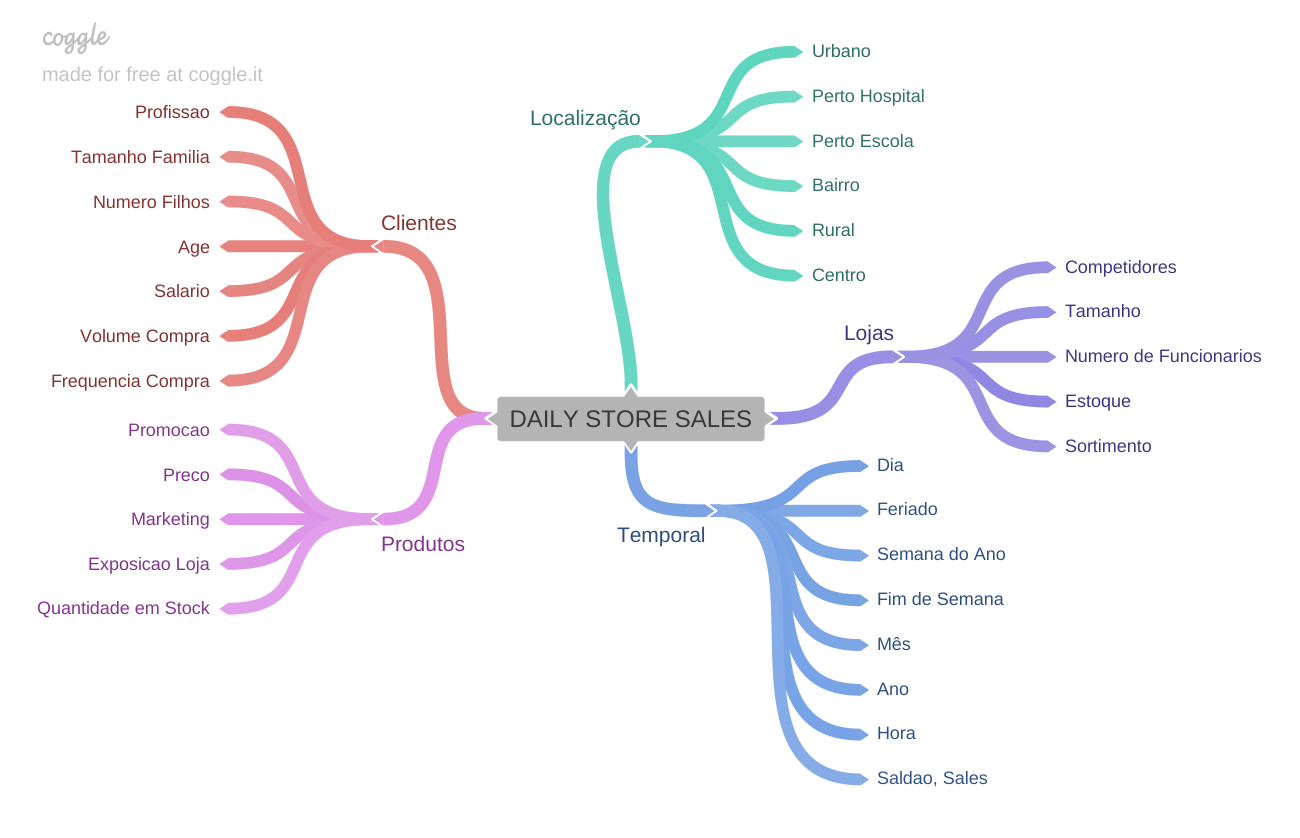

In [22]:
Image('img/DAILY_STORE_SALES.png')

### 2.2) Criação das Hipóteses

#### 2.2.1. Hipoteses Loja
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.2.2. Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3. Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3) Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

### 2.4) Feature Engineering

In [23]:
# day
df2['day'] = df2['date'].dt.day

# month
df2['month'] = df2['date'].dt.month

# year
df2['year'] = df2['date'].dt.year

# week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# assortment
assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_map)

# state_holiday
state_holiday_map = { 'a': 'public holiday', 'b': 'Easter holiday', 'c': 'Christmas', '0': 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

# competition_open_since
df2['competition_open_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'] if x['competition_open_since_year'] != 0 else x['date'].year, \
    month=x['competition_open_since_month'] if x['competition_open_since_month'] != 0 else x['date'].month, day=1), axis=1)

# competition_duration
df2['competition_duration'] = df2.apply(lambda x: np.round((x['date'] - x['competition_open_since']).days / 30).astype(int) if x['date'] > x['competition_open_since']  else 0, axis=1)

# promo2_since
df2['promo2_since'] = df2.apply(lambda x: f"{x['promo2_since_year']}-{x['promo2_since_week']}" if  x['promo2_since_year'] != 0 else x['date'].strftime('%Y-%W'), axis=1)

df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo2_since'] ) / 7 ).apply(lambda x: x.days ).astype( int )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', \
    8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['month'].map( month_map )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ).astype('bool')
df2.loc[(df2['promo_time_week'] == 0) & (df2['is_promo'] == 1), 'promo_time_week'] = 1

# 3.0) Filtragem de Variáveis

In [24]:
df3 = df2.copy()

### 3.1) Filtragem das Linhas

In [25]:
df3 = df3.query('open == True & sales > 0')

### 3.2) Seleção das Colunas

In [26]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
#cols_drop_2 = ['customers', 'open', 'competition_open_since_month',
#       'competition_open_since_year', 'promo2_since_week',
#       'promo2_since_year', 'promo_interval', 'month_map']

df3.drop(columns=cols_drop, inplace=True)

# 4.0) Análise Exploratória de Dados

In [27]:
df4 = df3.copy()

### 4.1) Análise Univariada

#### 4.1.2) Variável Target

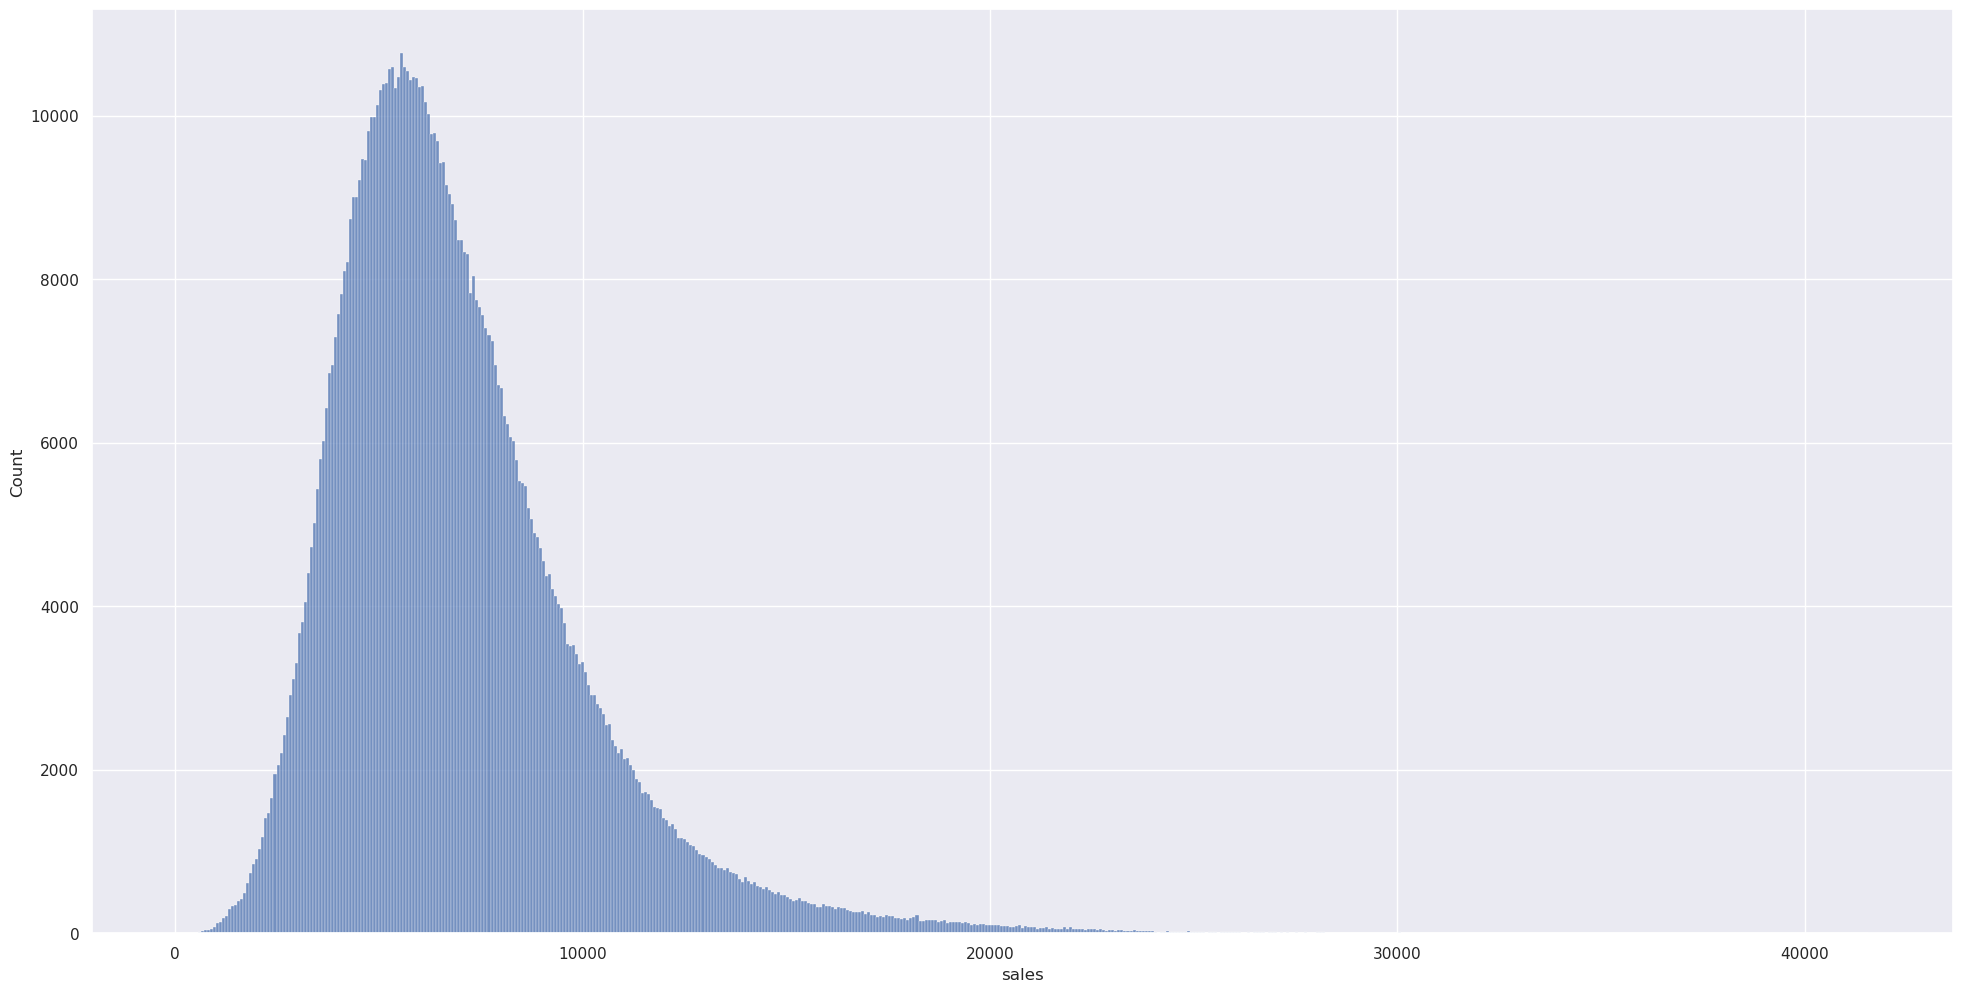

In [28]:
sns.histplot(df4['sales']);

#### 4.1.2) Variáveis Numéricas

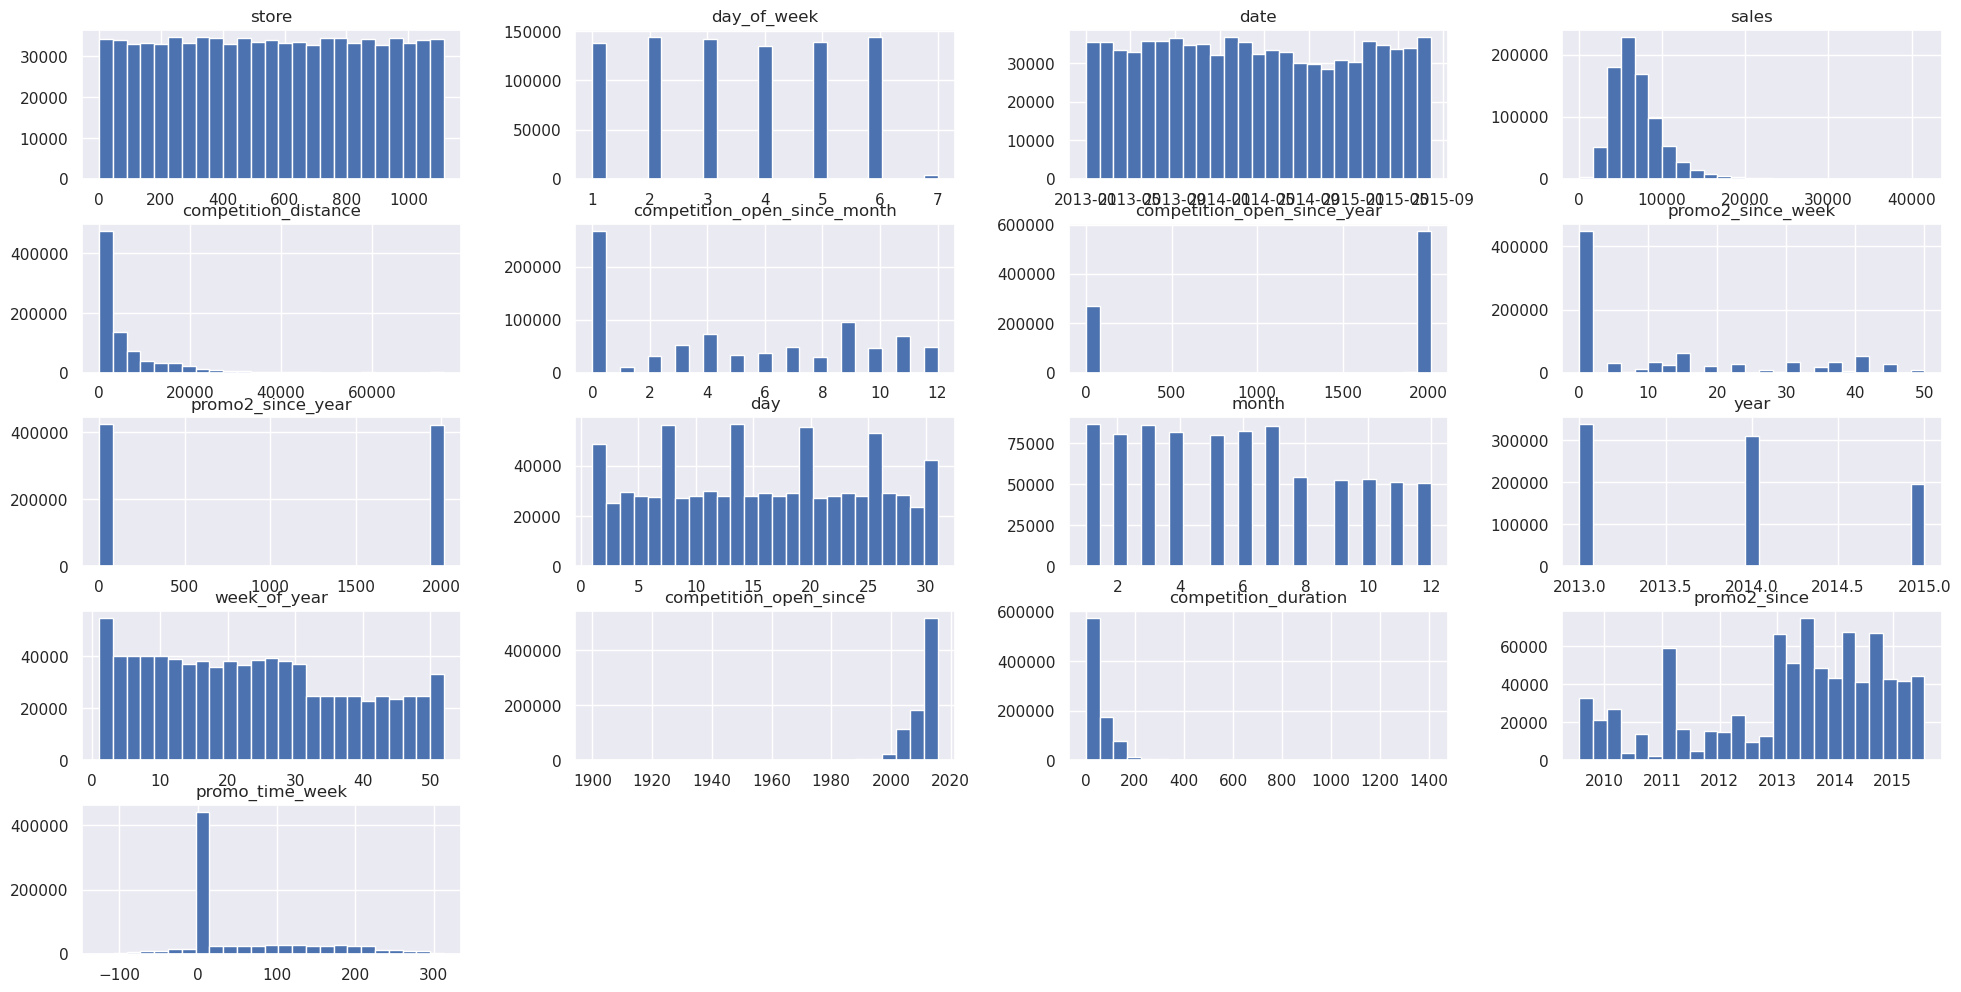

In [29]:
num_attr = df4.select_dtypes(include=[int, float, 'datetime64[ns]'])
num_attr.hist(bins=25);

#### 4.1.3) Variáveis Categóricas

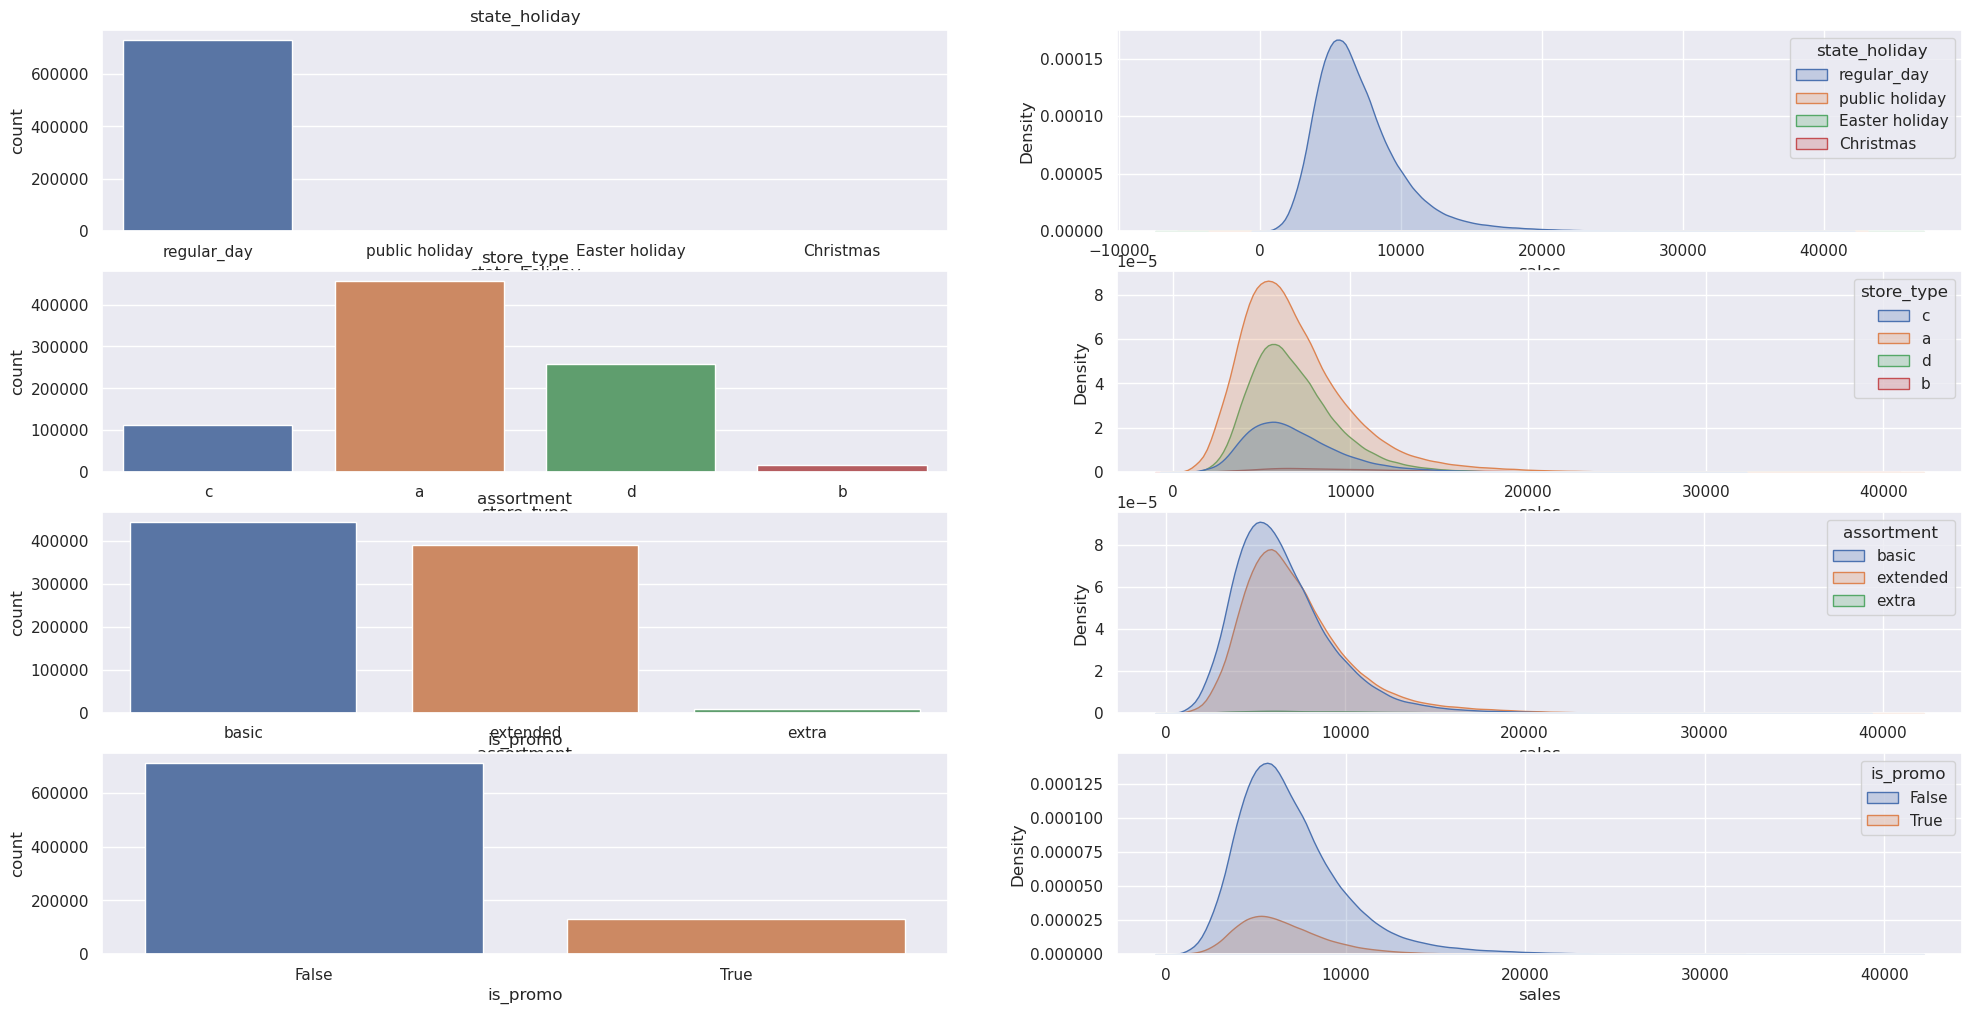

In [30]:
fig, ax = plt.subplots(4, 2)

# state_holiday
sns.countplot(data=df4, x='state_holiday', ax=ax[0, 0])

sns.kdeplot(data=df4, x='sales', hue='state_holiday', fill=True, ax=ax[0, 1])
ax[0, 0].set_title('state_holiday', fontsize=12)

# store_type
sns.countplot(data=df4, x='store_type', ax=ax[1, 0])

sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True, ax=ax[1, 1])
ax[1, 0].set_title('store_type', fontsize=12)

# assortment
sns.countplot(data=df4, x='assortment', ax=ax[2, 0])

sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True, ax=ax[2, 1])
ax[2, 0].set_title('assortment', fontsize=12)

# is_promo
sns.countplot(data=df4, x='is_promo', ax=ax[3, 0])

sns.kdeplot(data=df4, x='sales', hue='is_promo', fill=True, ax=ax[3, 1])
ax[3, 0].set_title('is_promo', fontsize=12)

plt.show()

### 4.2) Análise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais.

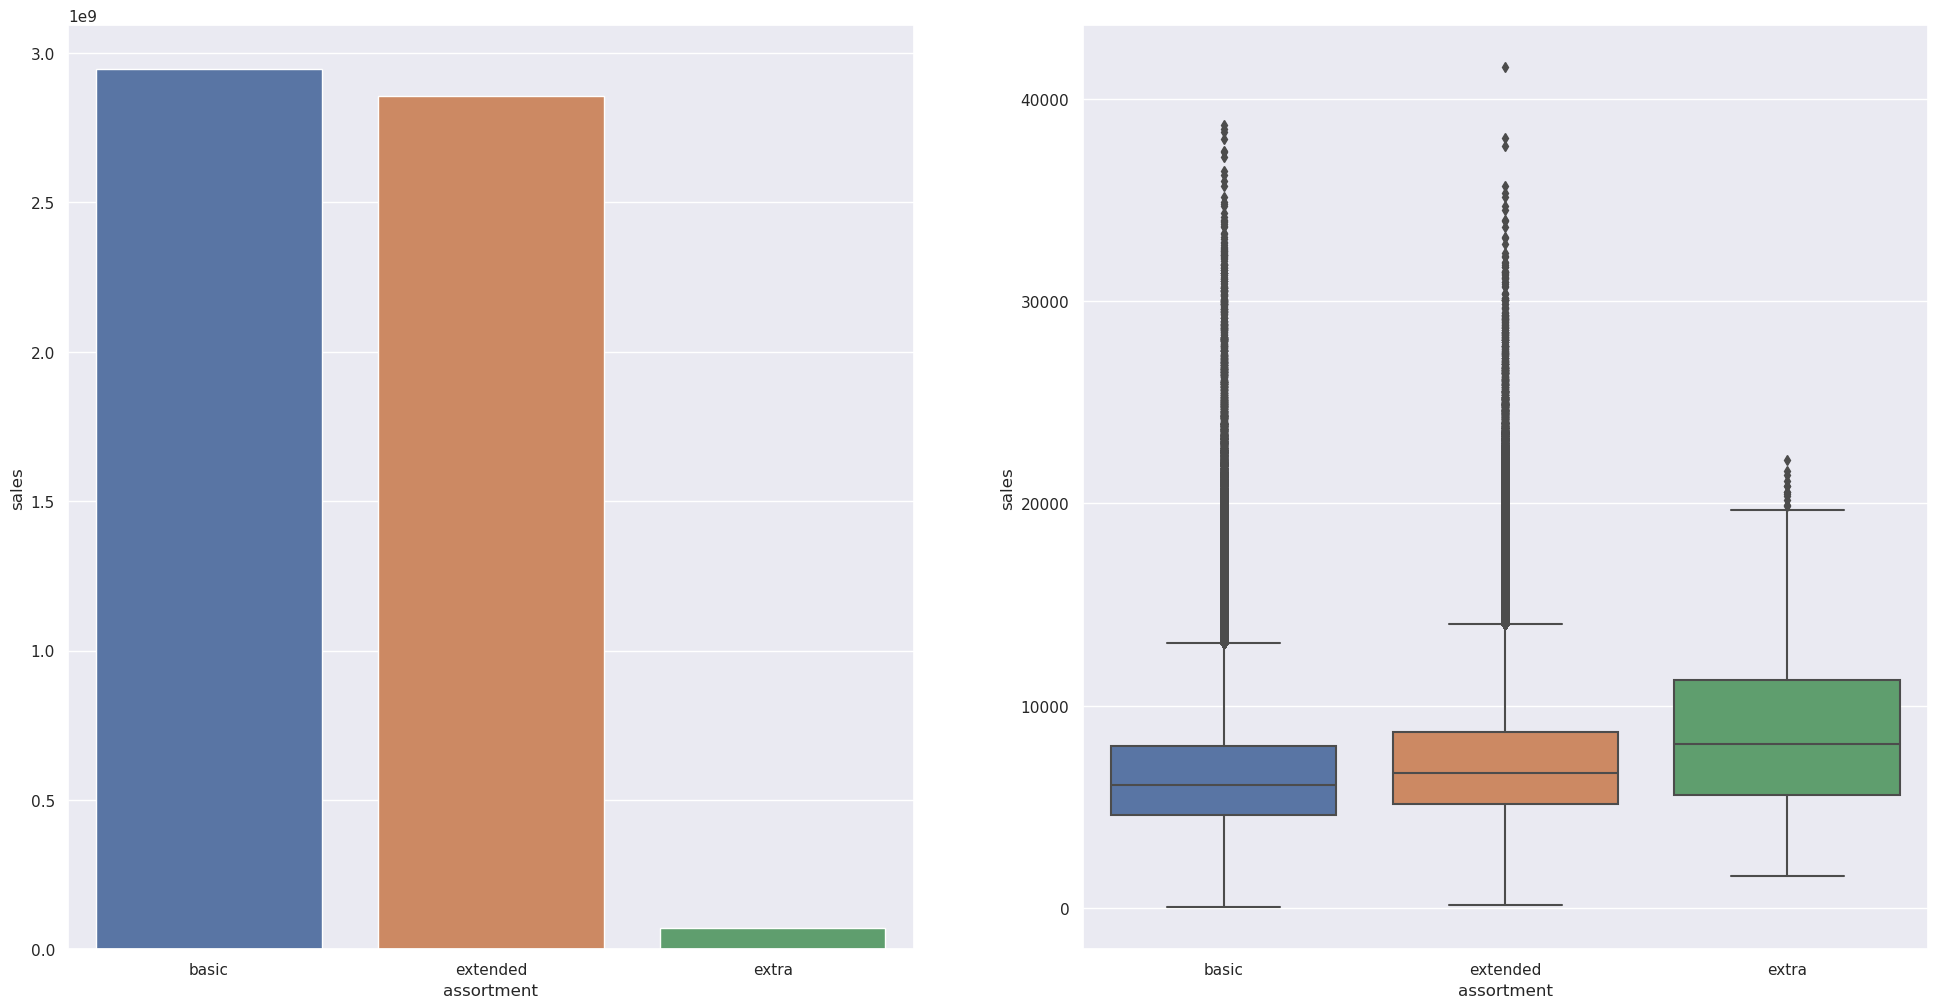

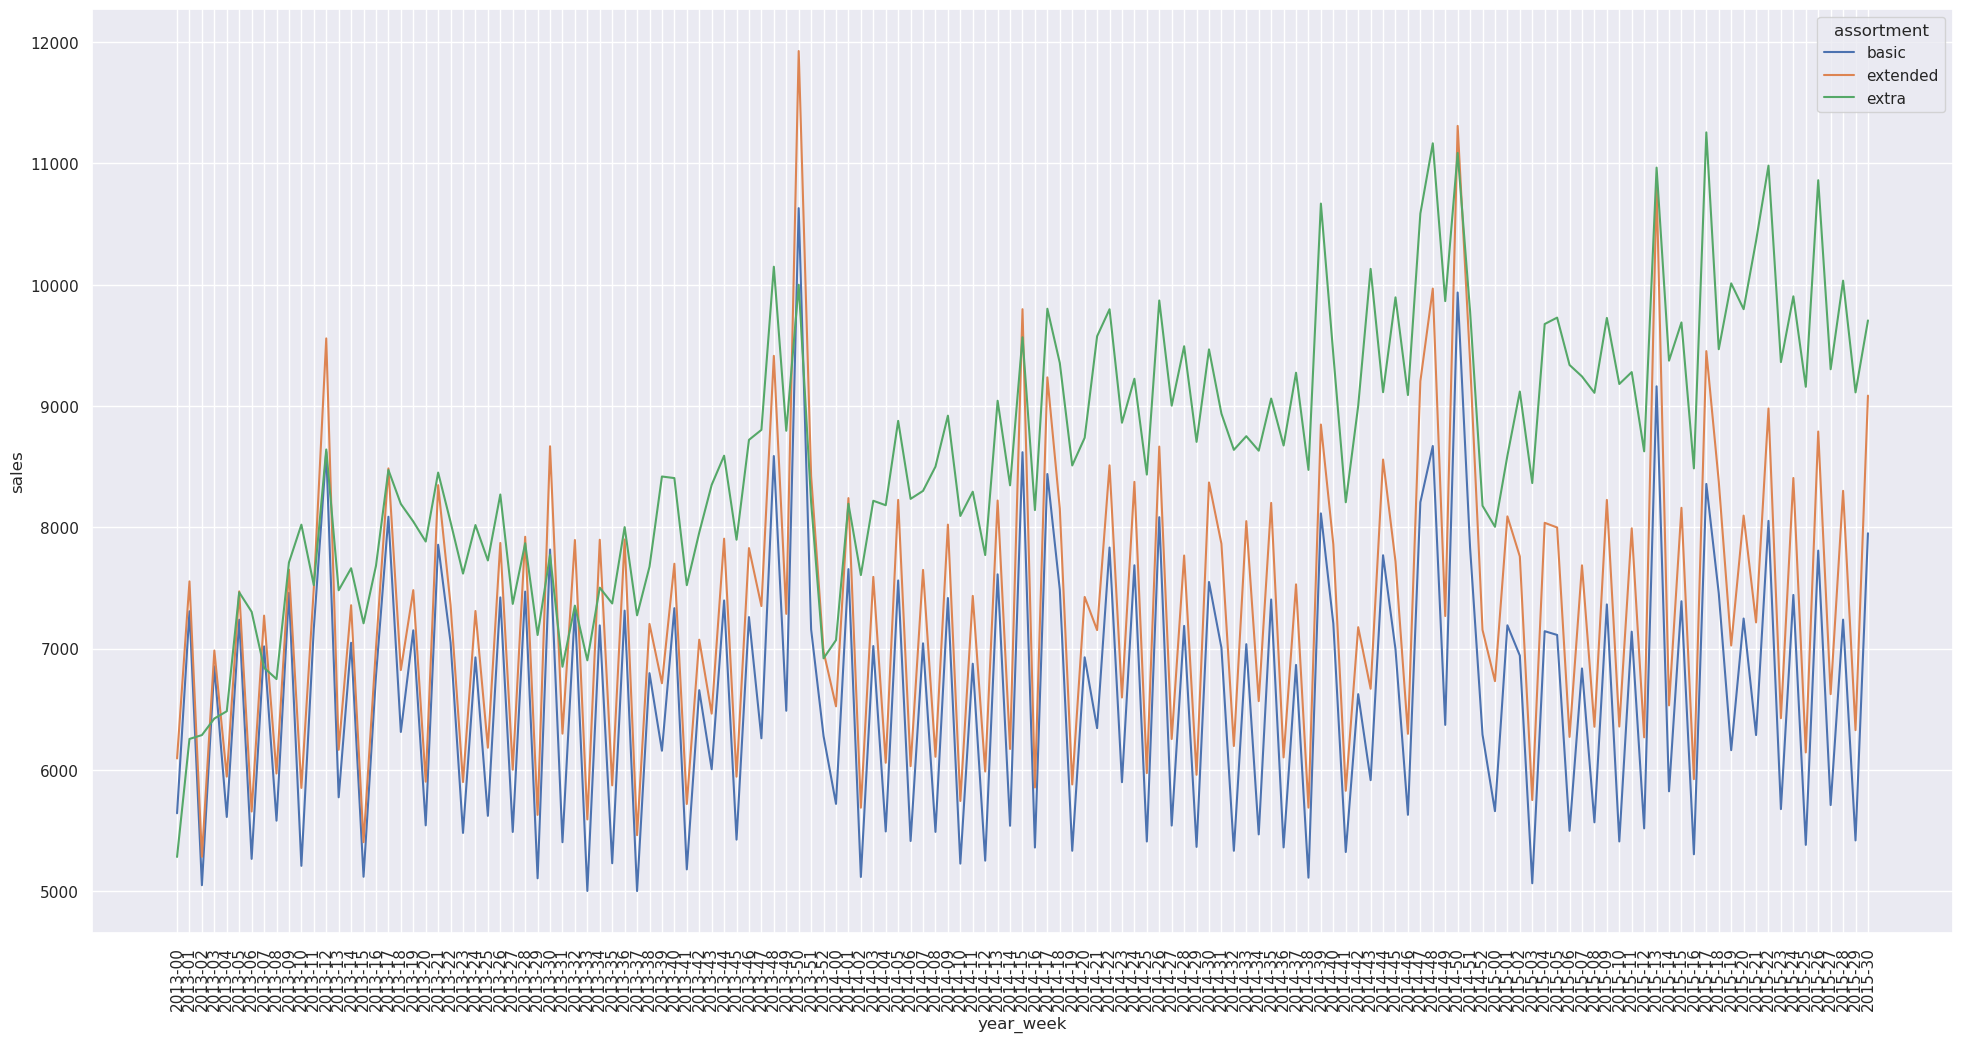

In [31]:
df_h1 = df4.groupby('assortment').agg({'sales': 'sum'}).reset_index()
df_h1_2 = df4.groupby(['year_week', 'assortment']).agg({'sales': 'mean'}).reset_index()

fig, ax = plt.subplots(1, 2)

sns.barplot(data=df_h1, x='assortment', y='sales', ax=ax[0])
sns.boxplot(data=df4, y='sales', x='assortment', ax=ax[1])

fig, ax2 = plt.subplots()

sns.lineplot(data=df_h1_2, x='year_week', y='sales', hue='assortment', ax=ax2)
ax2.set_xticklabels(df_h1_2['year_week'].unique(), rotation=90)

plt.show()

#### H2. Lojas com competidores mais próximos deveriam vender menos.

In [32]:
df_h2 = df4.loc[(df4['competition_duration'] > 0) & (df4['competition_distance'] > 0), ['competition_duration', 'competition_distance', 'sales']]
df_h2['bins'] = pd.qcut(df_h2.loc[(df_h2['competition_duration'] > 0) & (df_h2['competition_distance'] > 0), 'competition_distance'], 20, precision=1)

df_h2_1 = df_h2.groupby('bins').agg({'sales': 'mean'}).reset_index()

In [33]:
df4.loc[df4['competition_distance'] == 0, ['competition_duration', 'competition_distance', 'sales']].shape

(2186, 3)

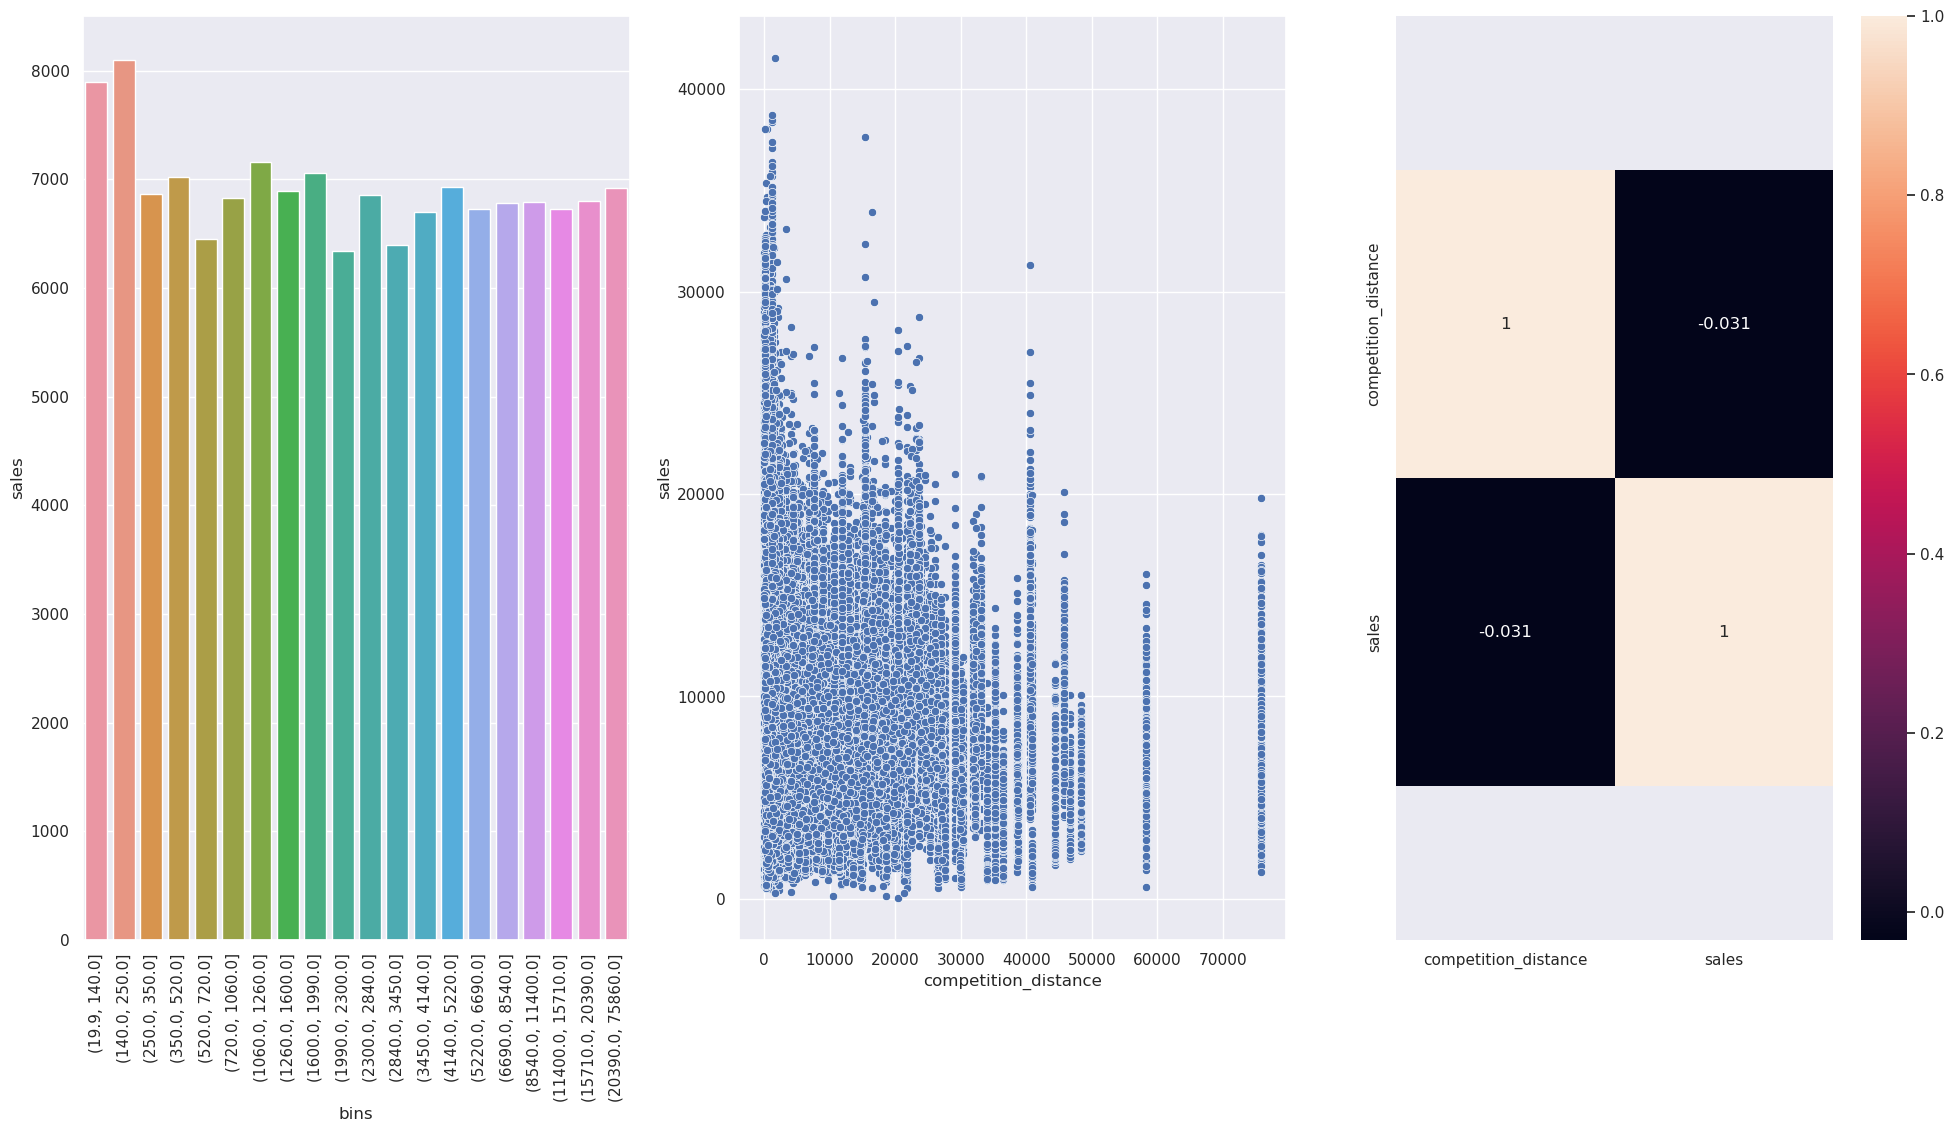

In [34]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h2_1, x='bins', y='sales', ax=ax[0])
ax[0].set_xticklabels(df_h2_1['bins'], rotation=90)

sns.scatterplot(data=df4, x='competition_distance', y='sales', ax=ax[1])

x = sns.heatmap( df_h2[['competition_distance', 'sales']].corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

plt.show()

#### H3. Lojas com competidores à mais tempo deveriam vender mais.

In [35]:
df_h3 = df4[['competition_duration', 'sales']]
df_h3['bins'] = pd.qcut(df_h3['competition_duration'], 15, duplicates='drop', precision=1)

df_h3_1 = df_h3.groupby('bins').agg({'sales': 'mean'}).reset_index()

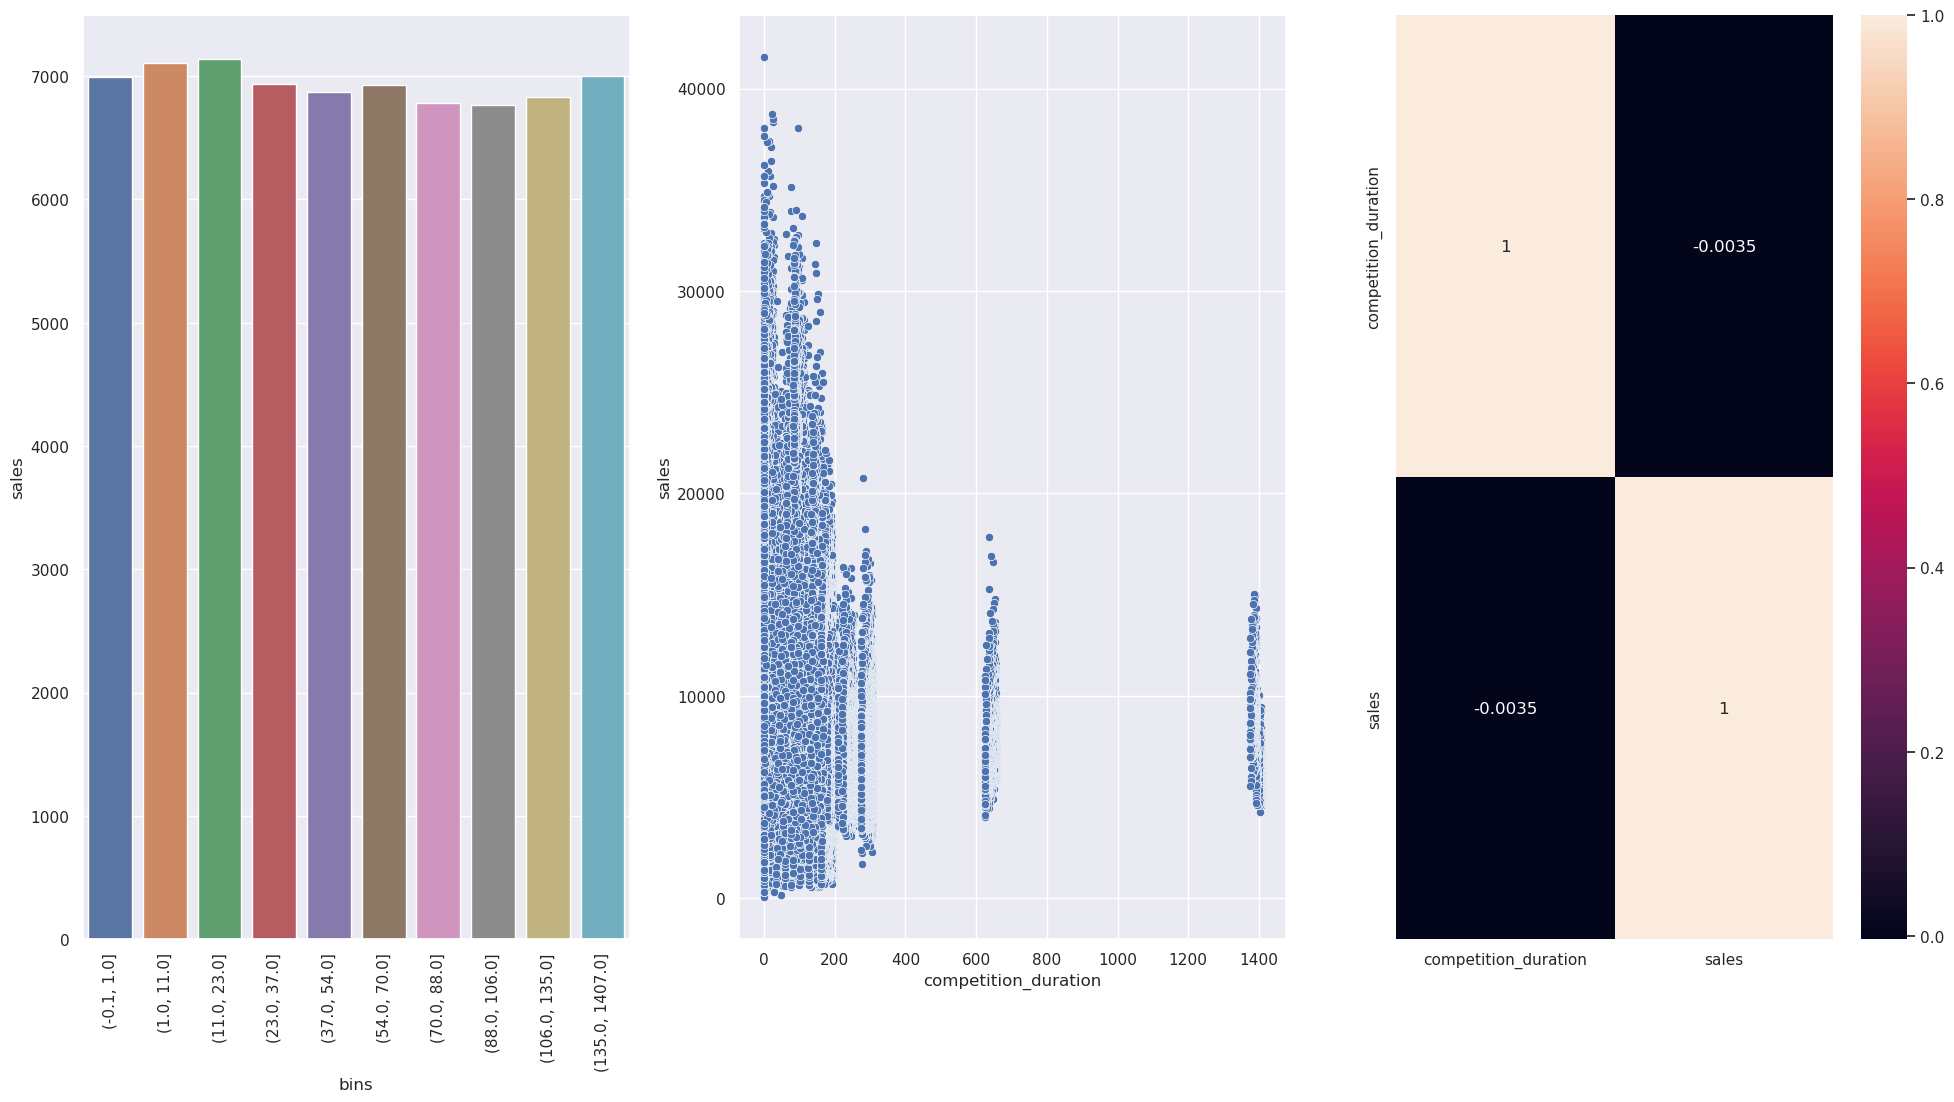

In [36]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h3_1, x='bins', y='sales', ax=ax[0])
ax[0].set_xticklabels(df_h3_1.bins, rotation=90)

sns.scatterplot(data=df_h3, x='competition_duration', y='sales', ax=ax[1])

ax[2] = plot_2_var_corr(df4, 'competition_duration', 'sales')

plt.show()

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

In [37]:
df_h4 = df4.loc[(df4['is_promo'] == True), ['promo_time_week', 'sales']]
df_h4['bins'] = pd.qcut(df_h4['promo_time_week'], 15, precision=1)

df_h4_1 = df_h4.groupby('promo_time_week').agg({'sales': 'median'}).reset_index()
df_h4_2 = df_h4.groupby('bins').agg({'sales': 'median'}).reset_index()

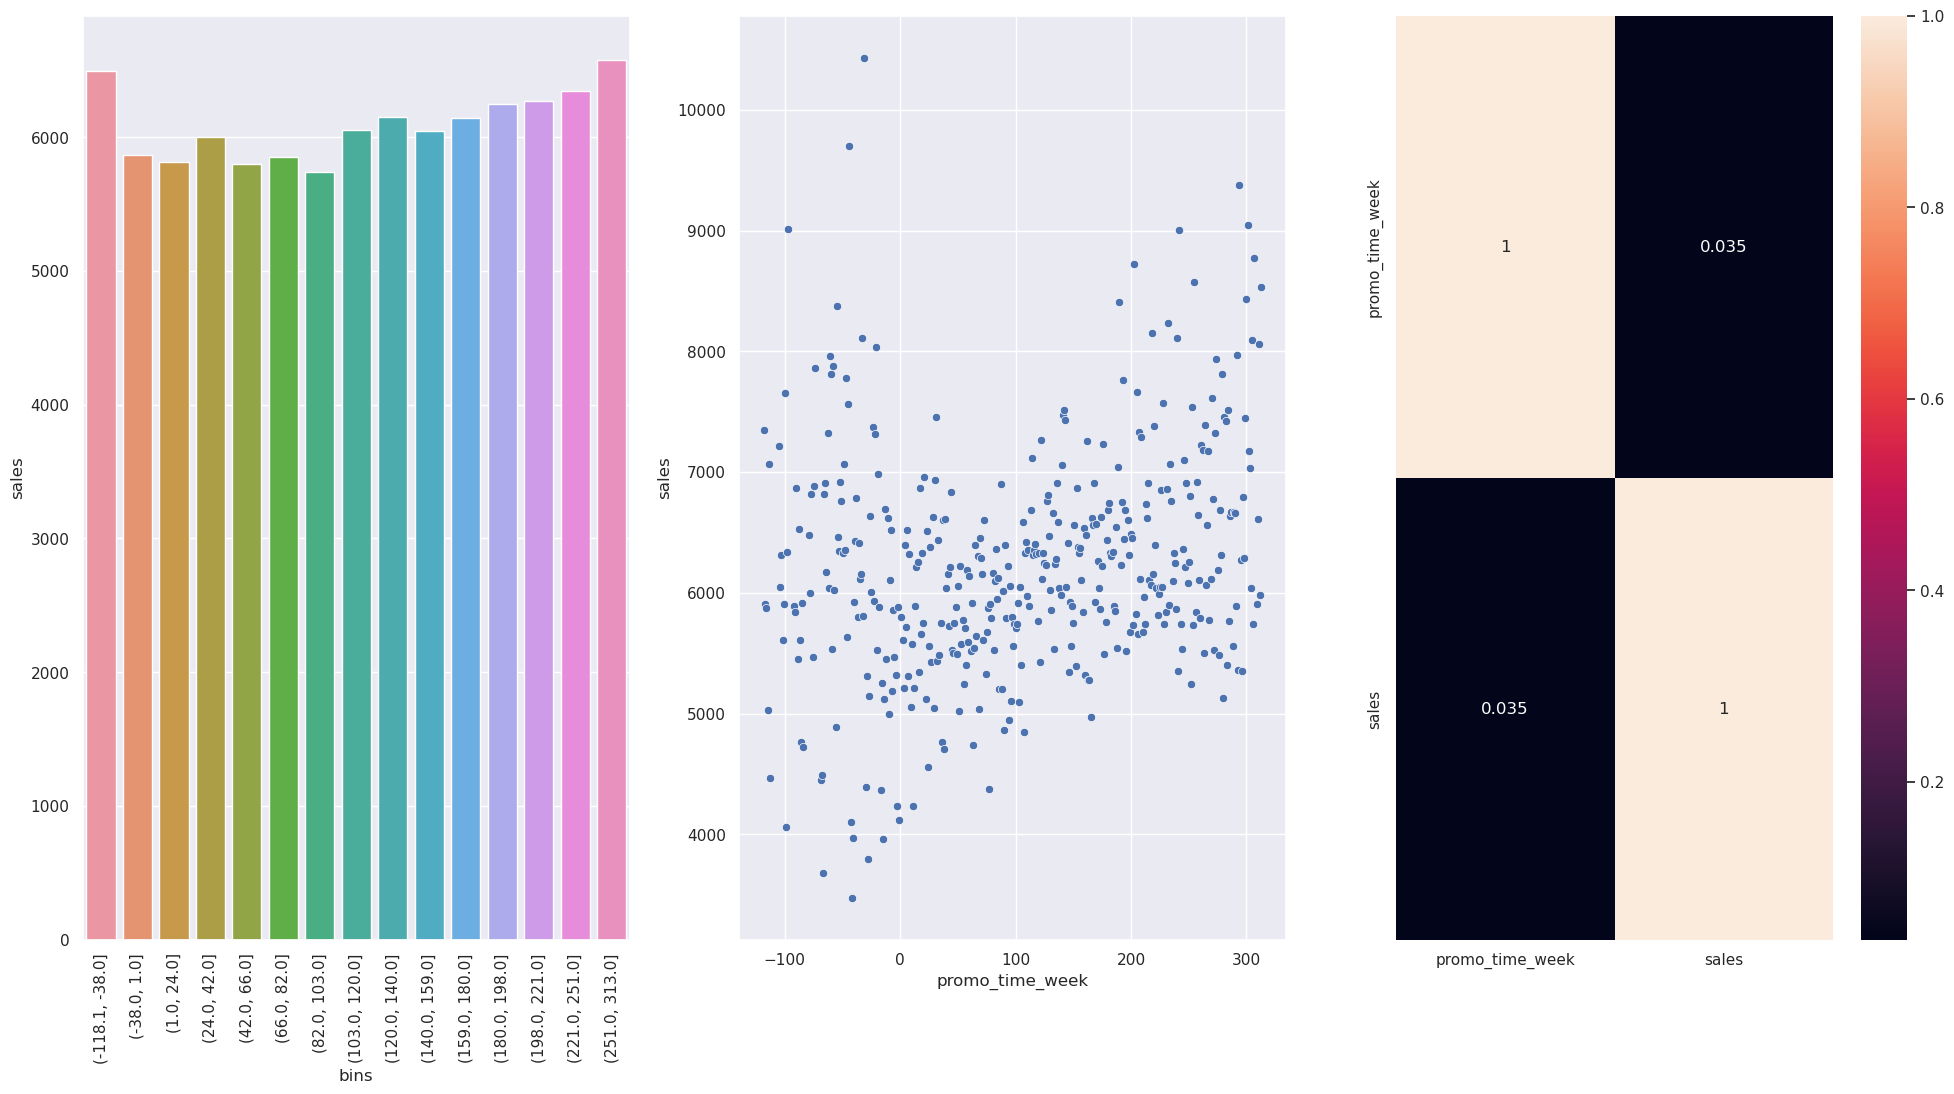

In [38]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h4_2, x='bins', y='sales', ax=ax[0])
ax[0].set_xticklabels(df_h4_2['bins'], rotation=90)

sns.scatterplot(data=df_h4_1, x='promo_time_week', y='sales', ax=ax[1]);

ax[2] = plot_2_var_corr(df4[df4['is_promo'] == True], 'promo_time_week', 'sales')

plt.show()

#### H5. Lojas com mais dias de promoção deveriam vender mais.

In [39]:
df_h5 = df4.loc[df4['promo'] == True].groupby(['store']).agg({'promo': 'sum', 'sales': 'mean'})
df_h5_2 = df_h5.groupby('promo').sales.mean().reset_index()

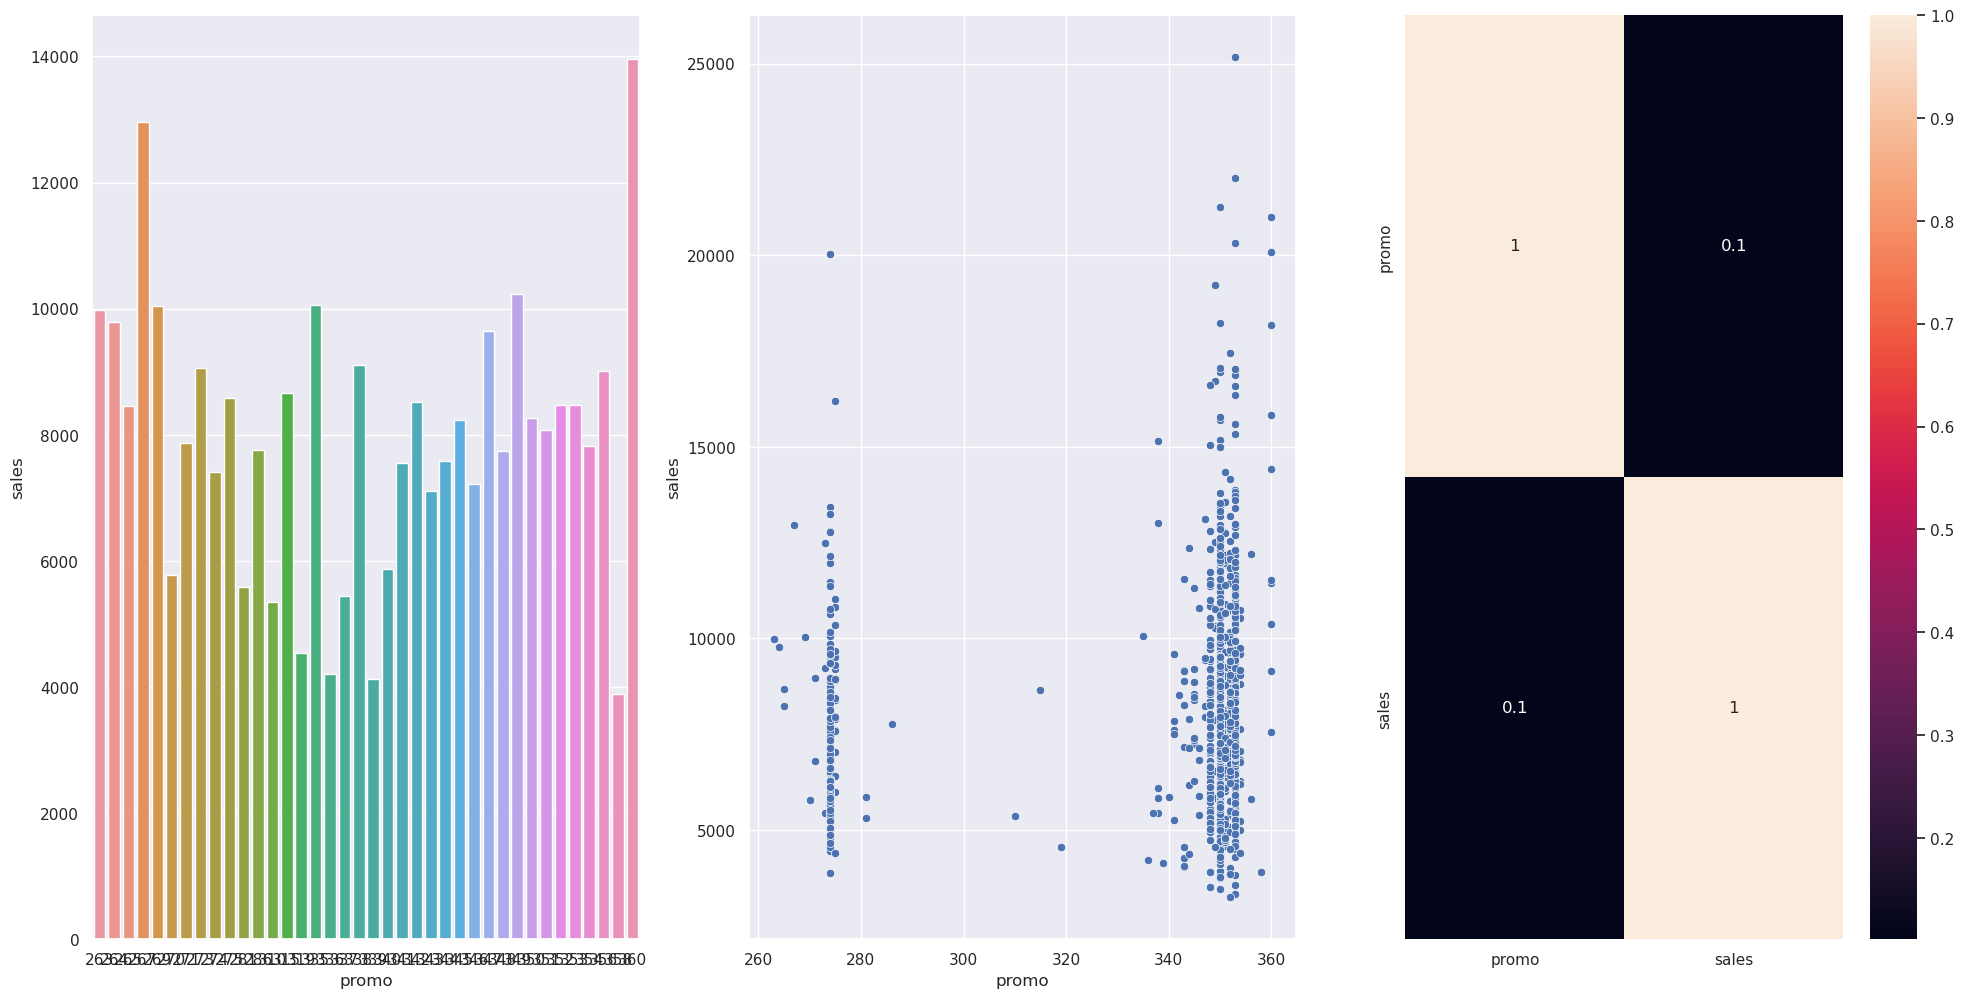

In [40]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h5_2, x='promo', y='sales', ax=ax[0])

sns.scatterplot(data=df_h5, x='promo', y='sales', ax=ax[1])

ax[2] = plot_2_var_corr(df_h5, 'promo', 'sales')

plt.show()

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.

In [41]:
df_h6_1 = df4.query("promo == True & promo2 == True").groupby('year_week').agg({'sales': 'mean'})
df_h6_2 = df4.query("promo == True & promo2 == False").groupby('year_week').agg({'sales': 'mean'})

In [42]:
df4.promo2.value_counts()

False    423292
True     421046
Name: promo2, dtype: int64

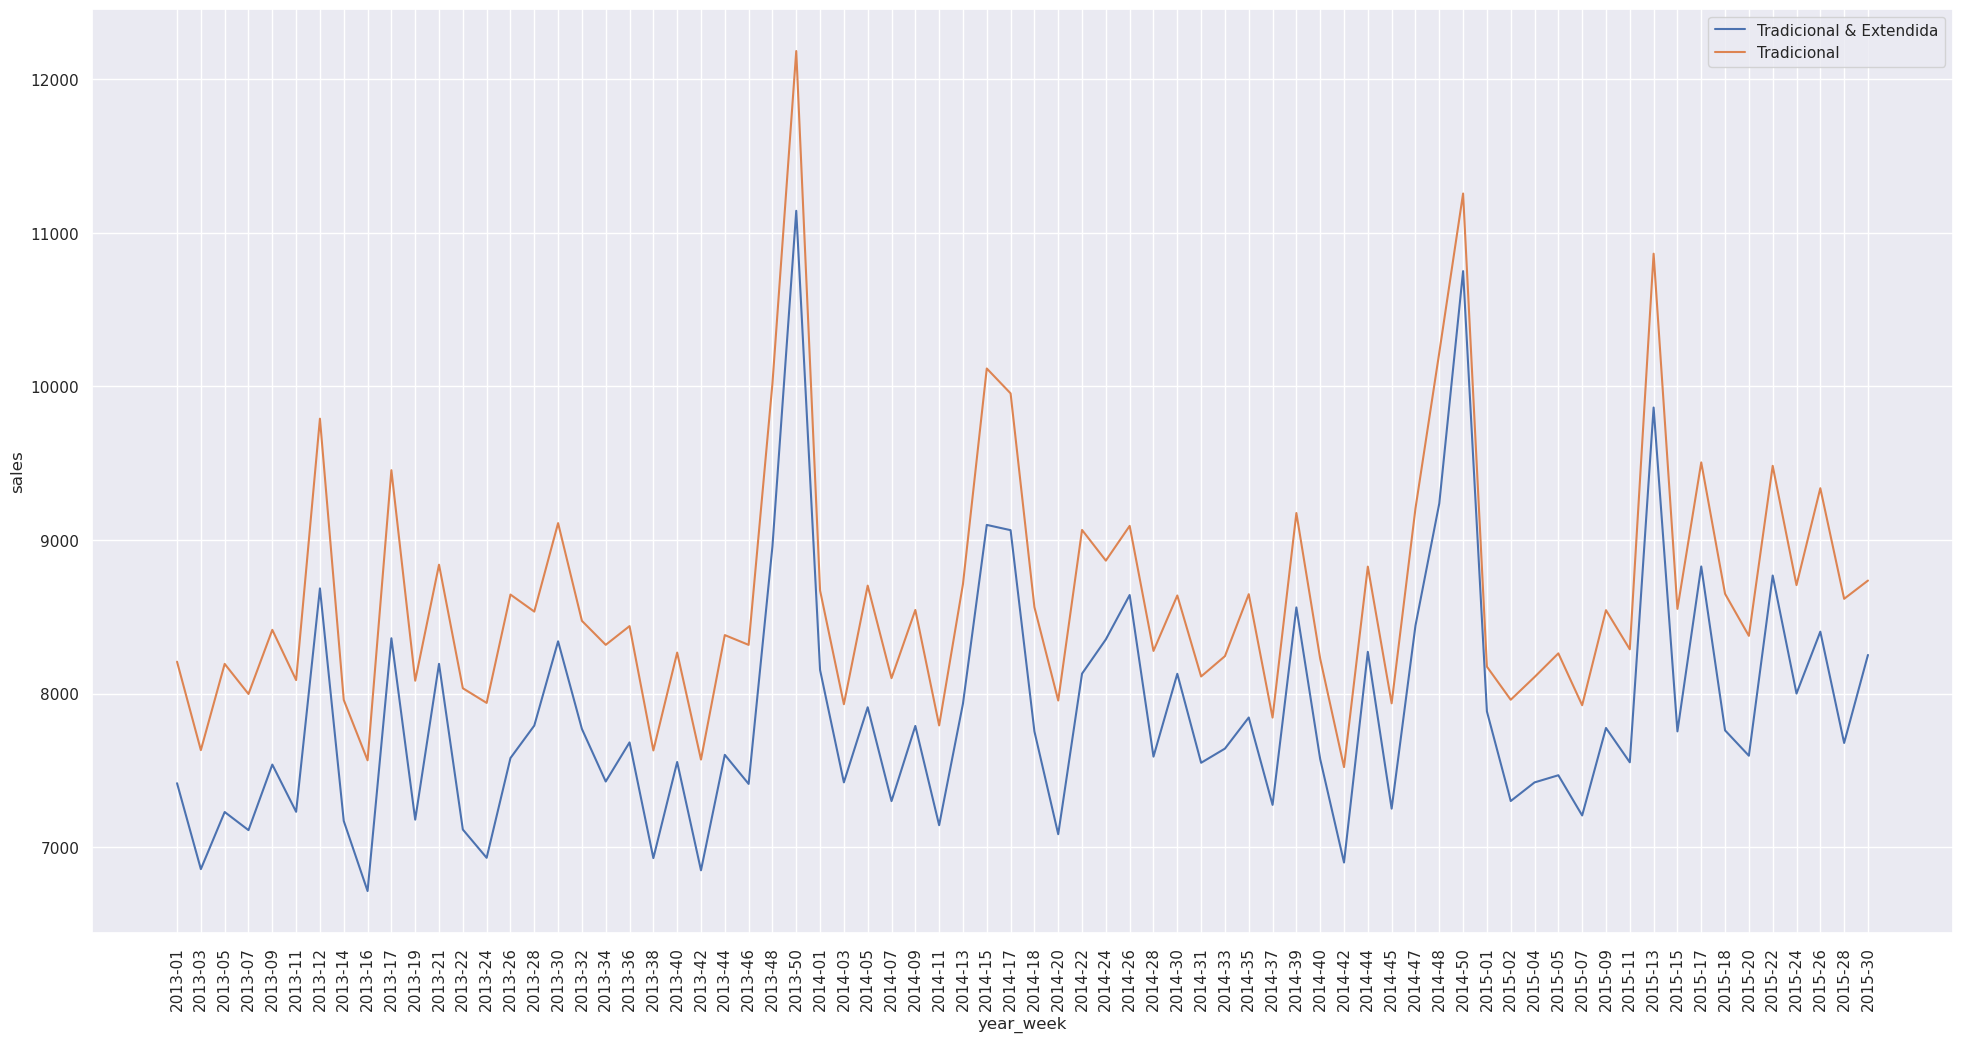

In [43]:
fig, ax = plt.subplots()

sns.lineplot(data=df_h6_1, x='year_week', y='sales', label='Tradicional & Extendida', ax=ax)
sns.lineplot(data=df_h6_2, x='year_week', y='sales', label='Tradicional', ax=ax)
plt.xticks(rotation=90)

plt.legend()
plt.show()

In [44]:
df4.loc[(df4['promo'] == True) & (df4['promo2'] == True)].shape

(187870, 25)

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

In [45]:
df_h7 = df4.query("state_holiday != 'regular_day'").groupby('state_holiday').agg({'sales': 'sum'}).reset_index()
df_h7_2 = df4.query("state_holiday != 'regular_day'").groupby(['year', 'state_holiday']).agg({'sales': 'sum'}).reset_index()

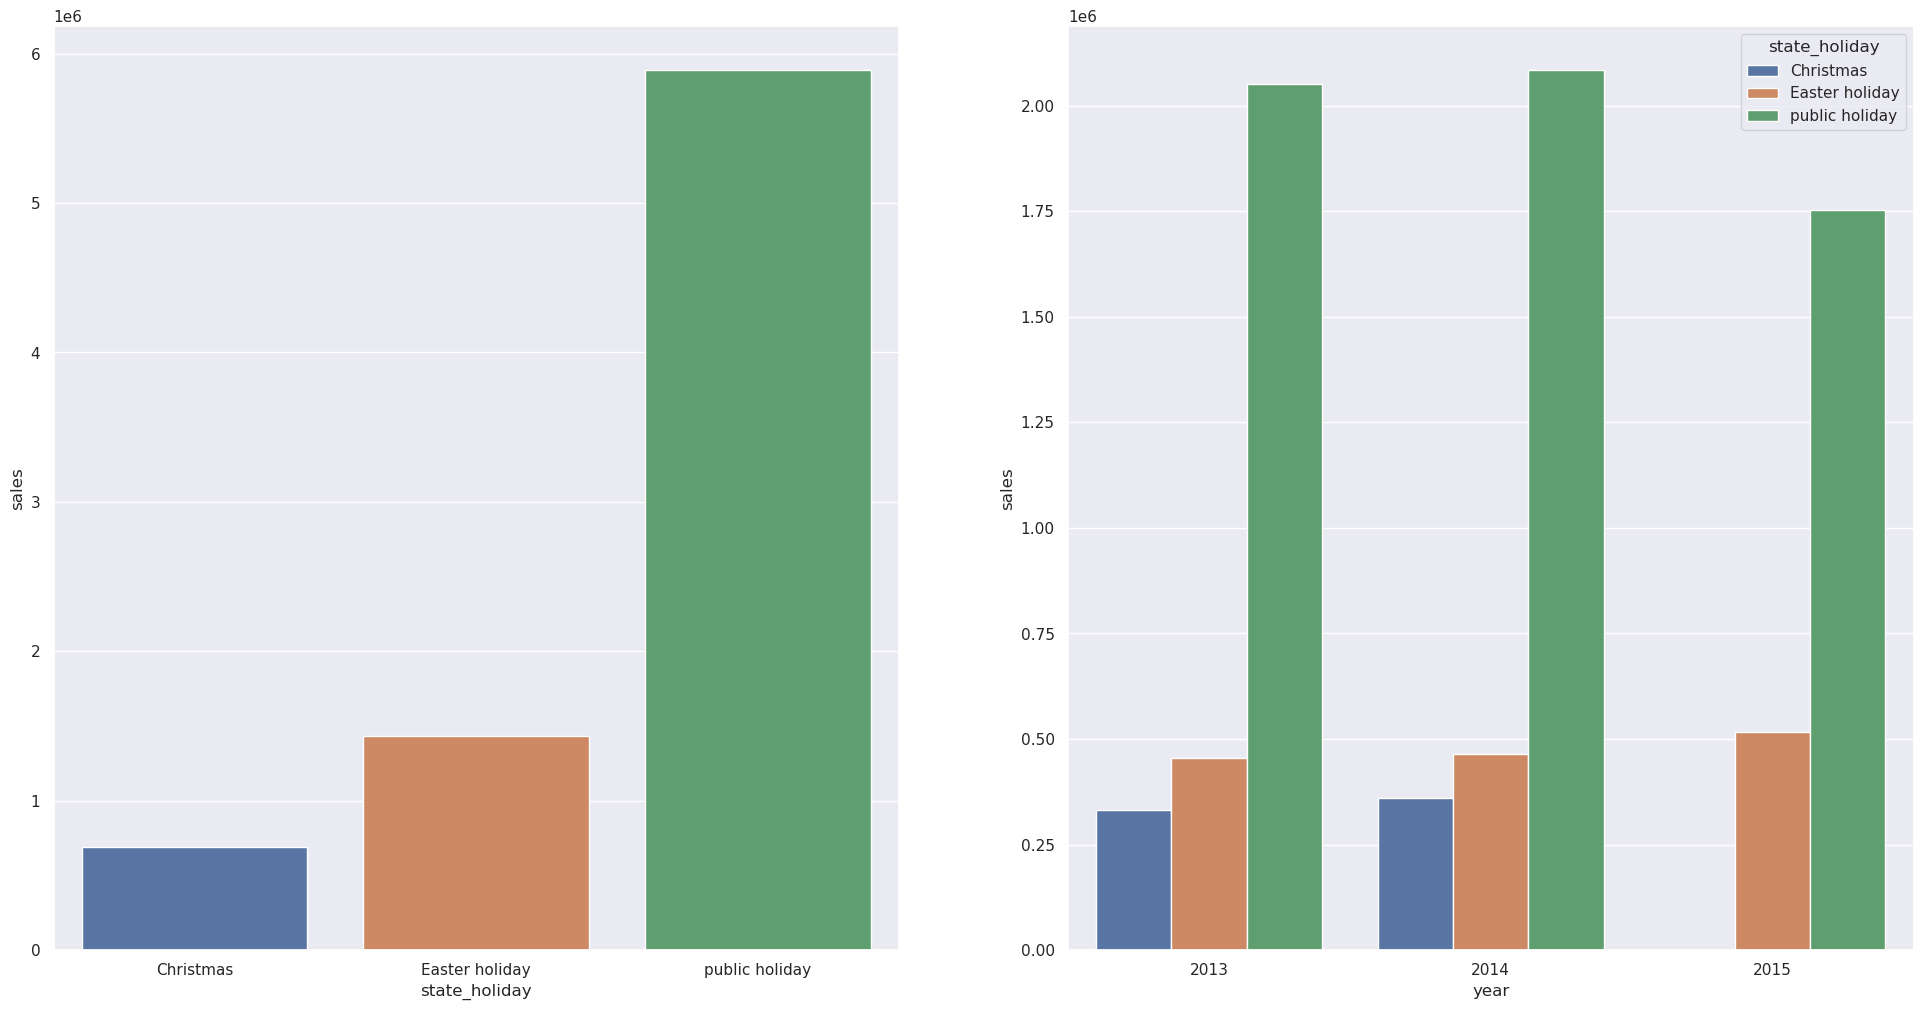

In [46]:
fig, ax = plt.subplots(1, 2)

sns.barplot(data=df_h7, x='state_holiday', y='sales', ax=ax[0])

sns.barplot(data=df_h7_2, x='year', y='sales', hue='state_holiday', ax=ax[1])

plt.show()

#### H8. Lojas deveriam vender mais ao longo dos anos.

In [47]:
df_h8 = df4.groupby(['year']).sales.mean().reset_index()
df_h8_2 = df4.groupby(['year']).sales.sum().reset_index()

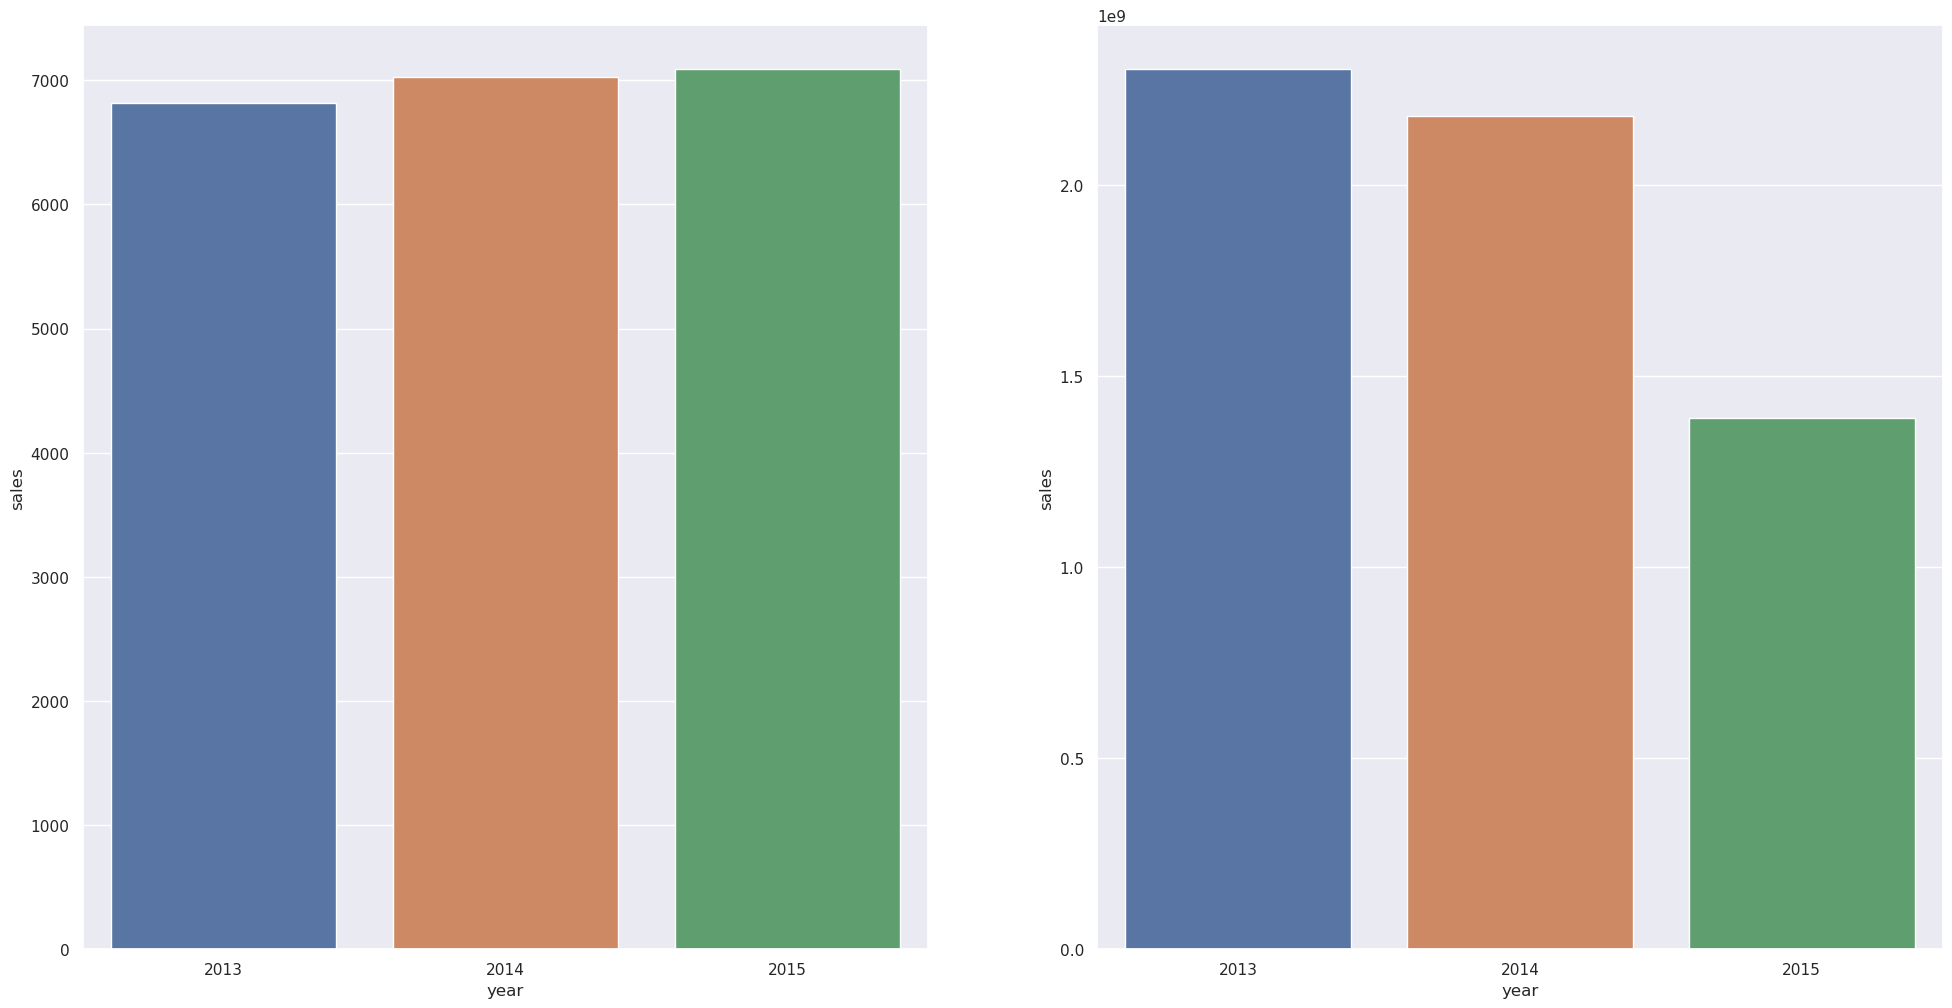

In [48]:
fig, ax = plt.subplots(1, 2)

sns.barplot(data=df_h8, x='year', y='sales', ax=ax[0])
sns.barplot(data=df_h8_2, x='year', y='sales', ax=ax[1])

plt.show()

#### H9. Lojas deveriam vender mais no segundo semestre do ano.

In [49]:
df_h9 = df4.loc[:, ['month', 'sales']]
df_h9['semester'] = ((df4['month'] - 1) // 6) + 1
df_h9_1 = df_h9.groupby('semester').sales.mean().reset_index()

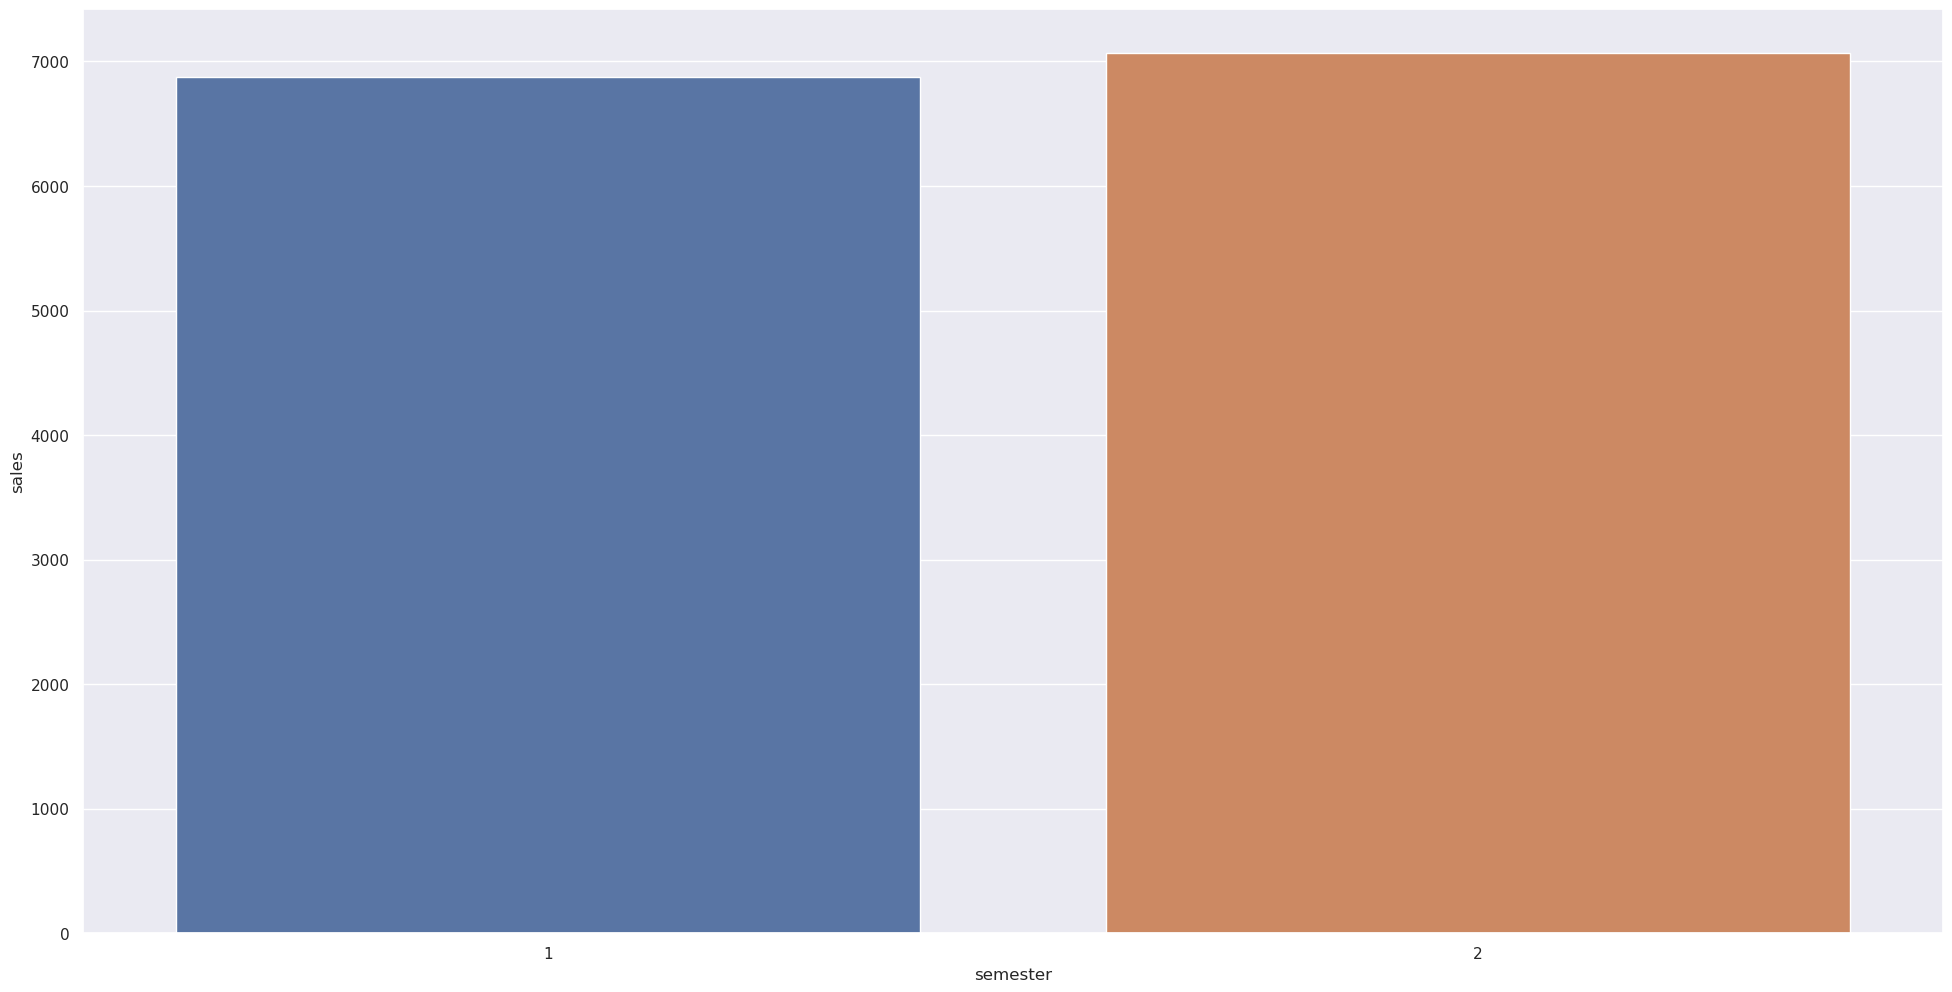

In [50]:
fig, ax = plt.subplots()

sns.barplot(data=df_h9_1, x='semester', y='sales')

plt.show()

In [51]:
df4[df4['year'] == 2015].month.unique()

array([7, 6, 5, 4, 3, 2, 1])

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

In [52]:
df_h10 = df4.loc[:, ['day', 'sales']].groupby('day').sales.mean().reset_index()
df_h10 = df_h10.groupby(df_h10['day'] > 10).sales.mean().reset_index()

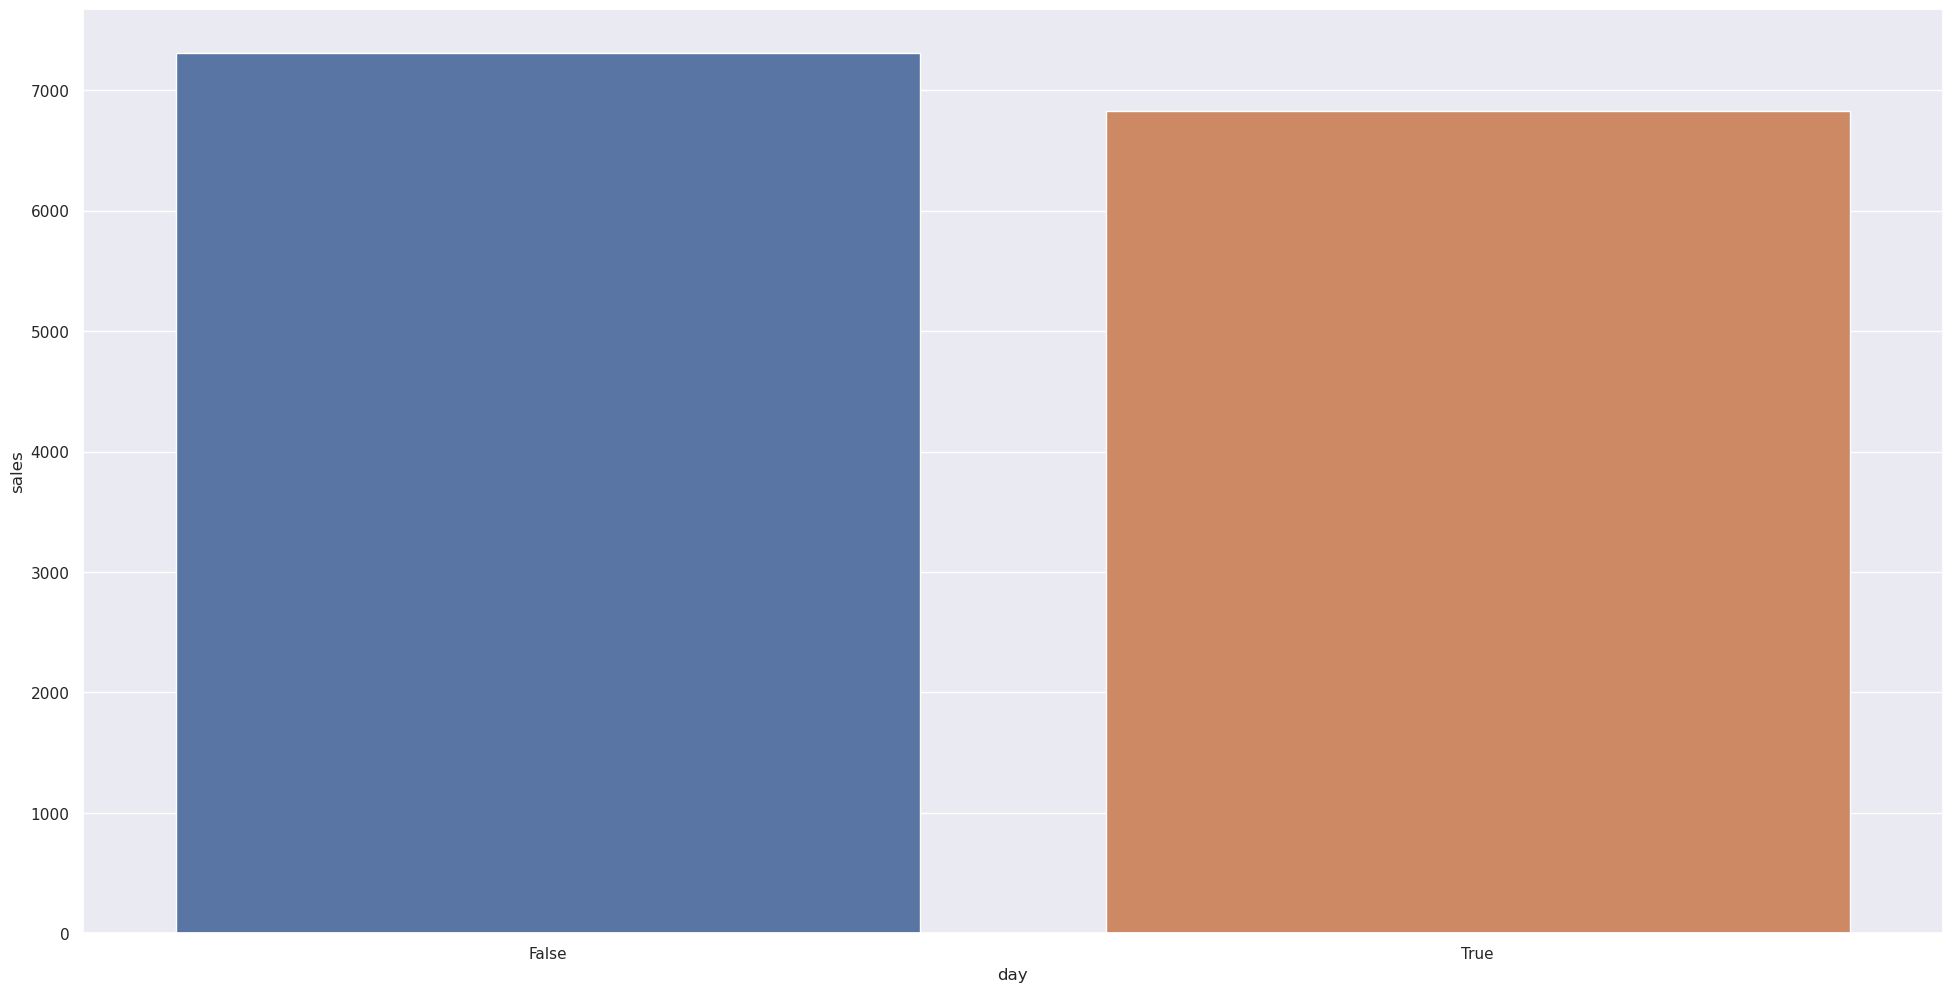

In [53]:
fig, ax = plt.subplots()

sns.barplot(data=df_h10, x='day', y='sales')

plt.show()

#### H11. Lojas deveriam vender menos aos finais de semana.

In [54]:
df_h11 = df4.loc[:, ['day_of_week', 'sales']].groupby('day_of_week').sales.mean().reset_index()
df_h11 = df_h11.groupby(df_h11['day_of_week'] > 5).sales.mean().reset_index()

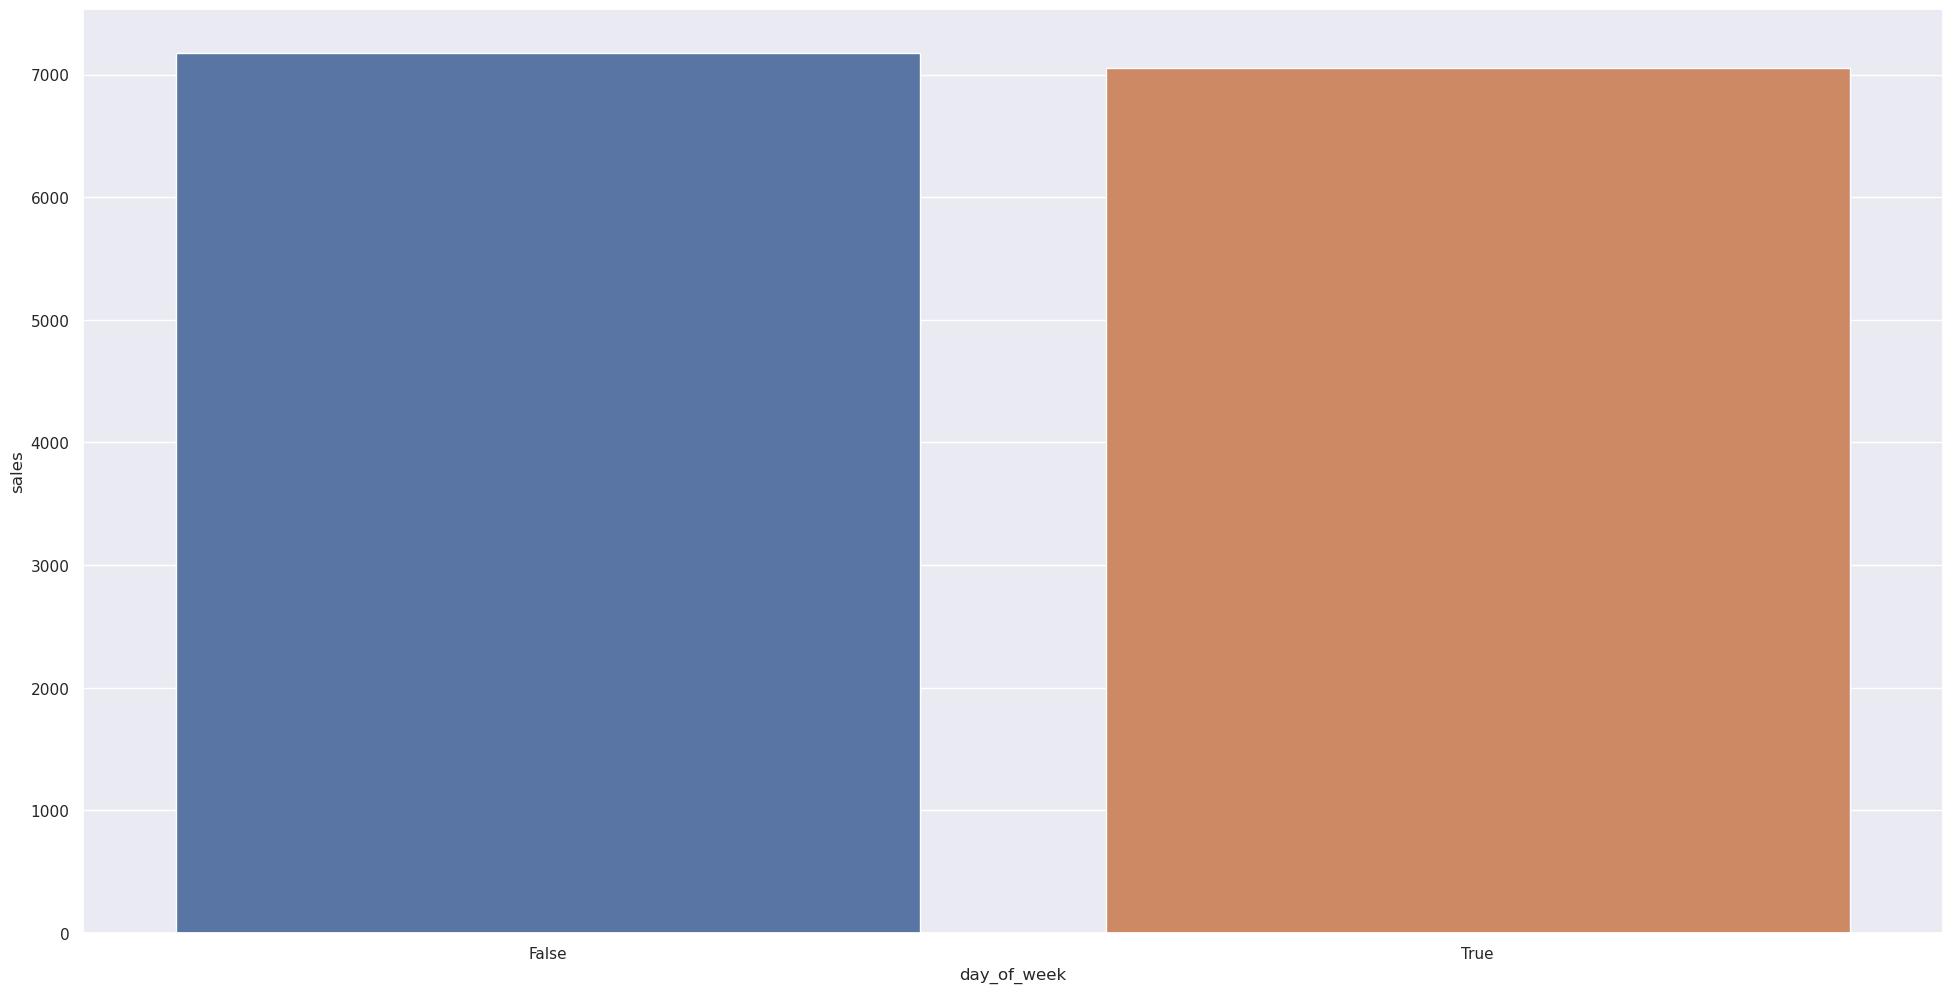

In [55]:
fig, ax = plt.subplots()

sns.barplot(data=df_h11, x='day_of_week', y='sales')

plt.show()

#### H12. Lojas deveriam vender menos durante os feriados escolares.

In [56]:
df_h12 = df4.groupby('school_holiday').sales.mean().reset_index()

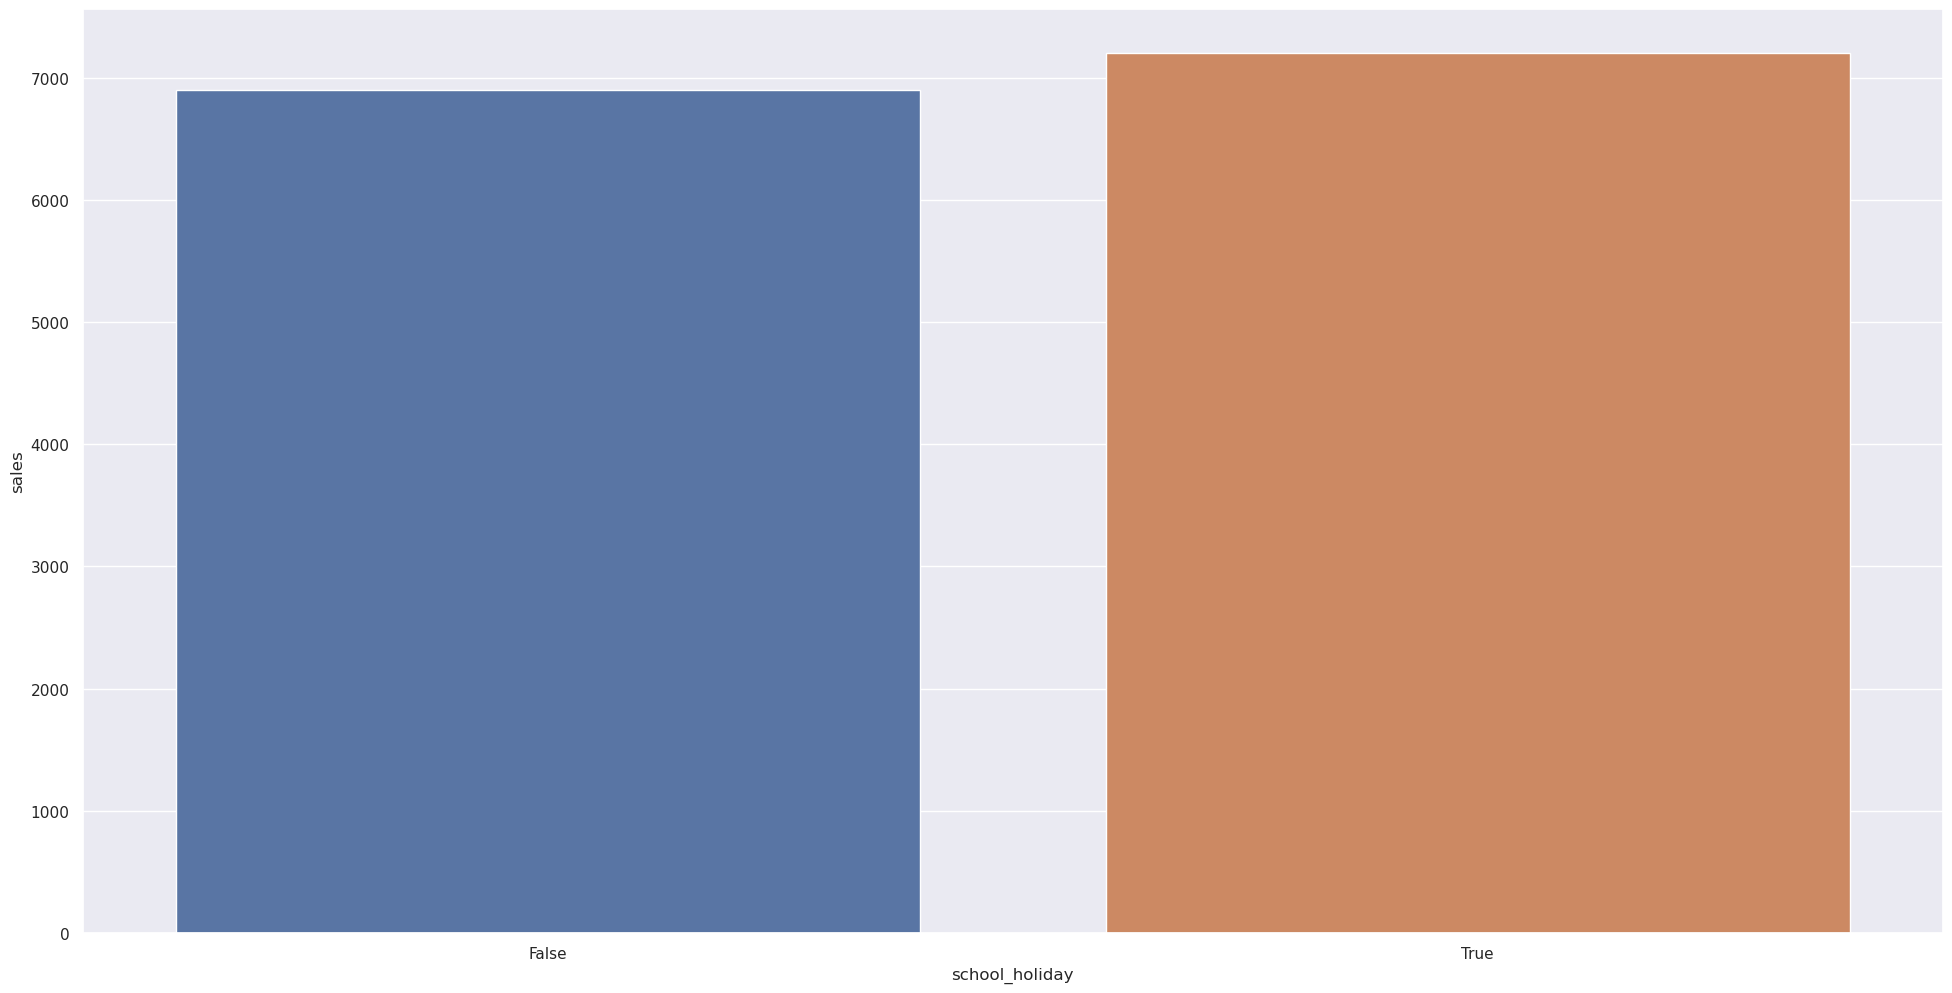

In [57]:
fig, ax = plt.subplots()

sns.barplot(data=df_h12, x='school_holiday', y='sales')

plt.show()

### 4.3) Análise Multivariada

#### 4.3.1) Variáveis Numéricas

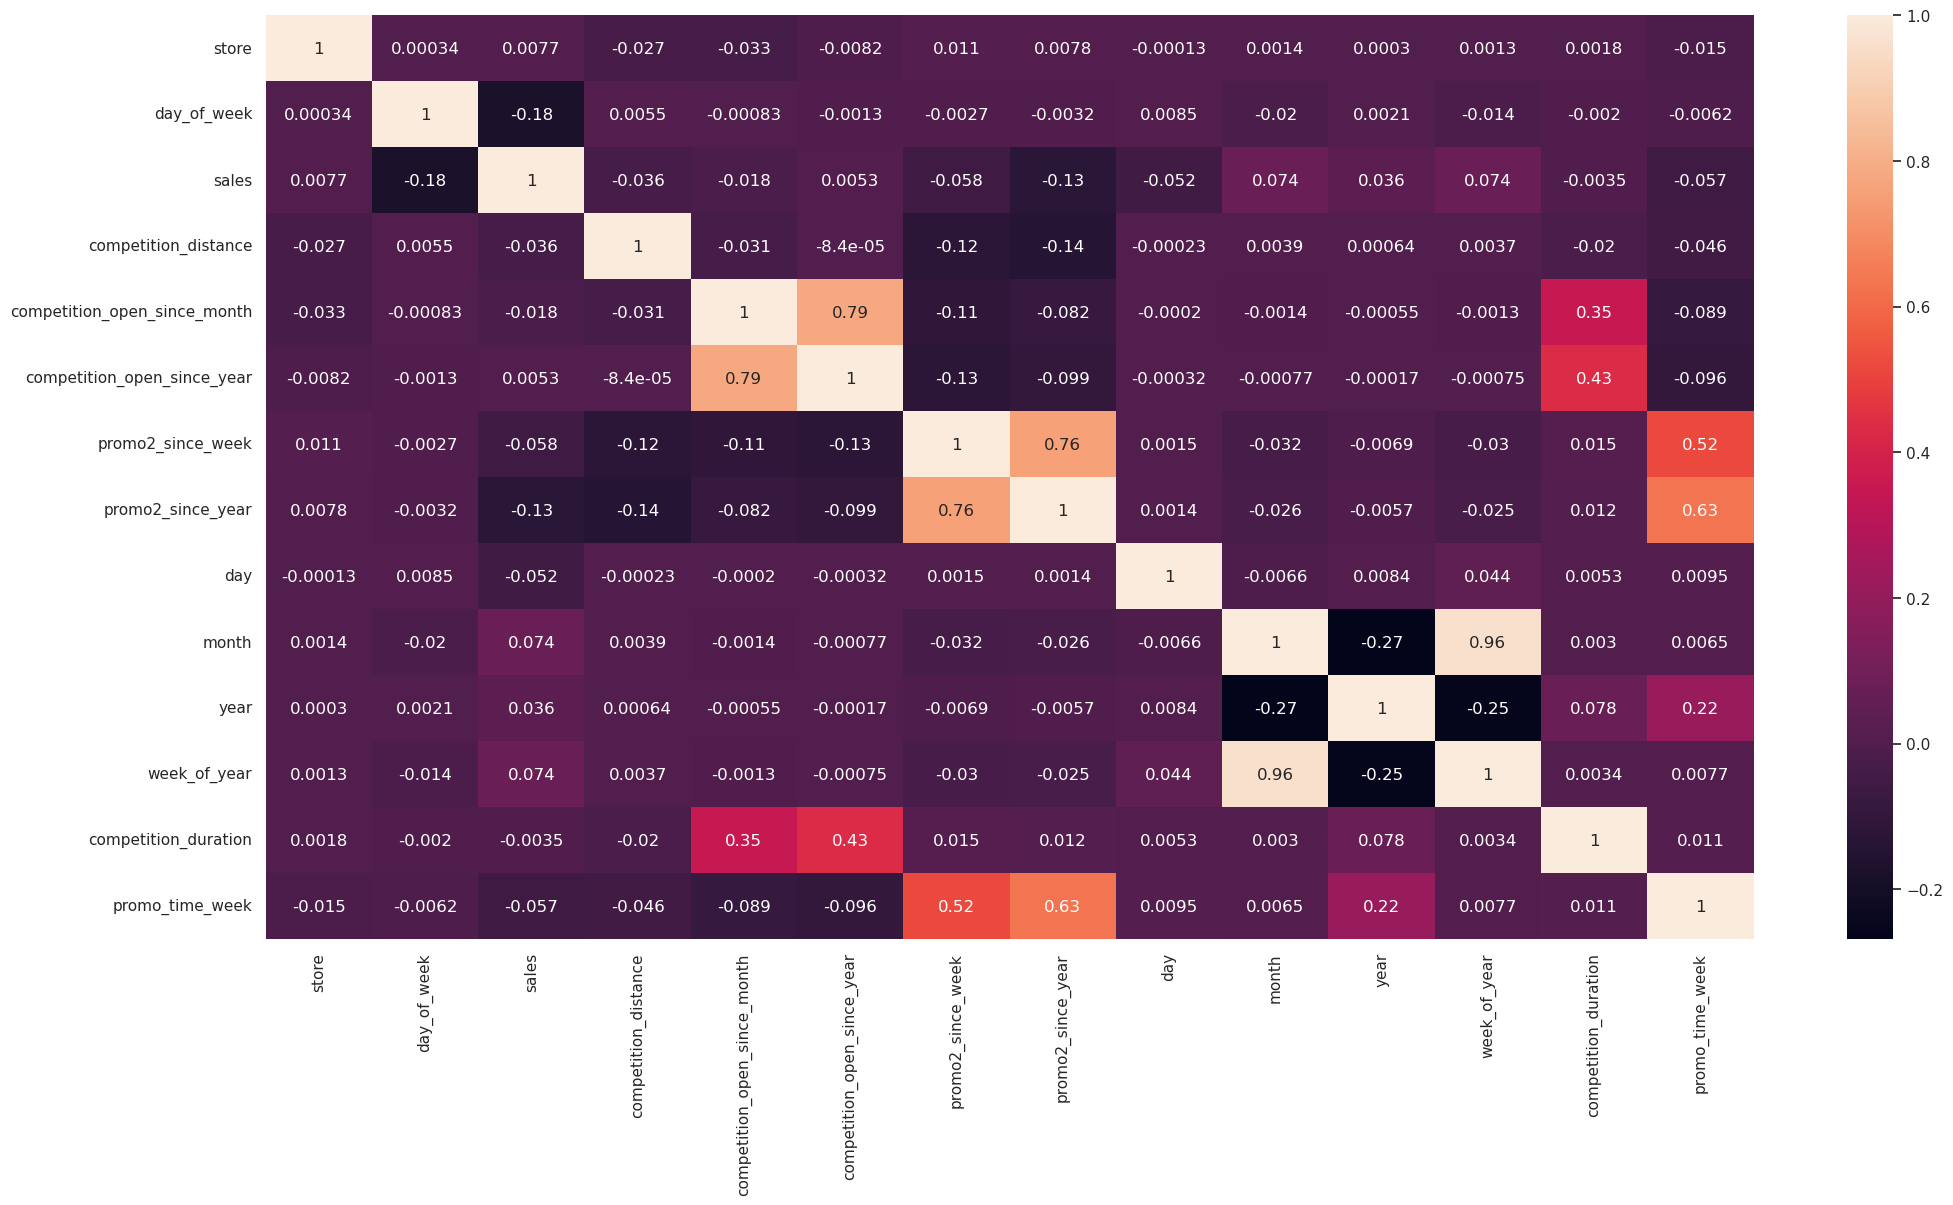

In [58]:
correlation = df4.select_dtypes(include=[int, float, 'datetime64[ns]']).corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### 4.3.2) Variáveis Categóricas

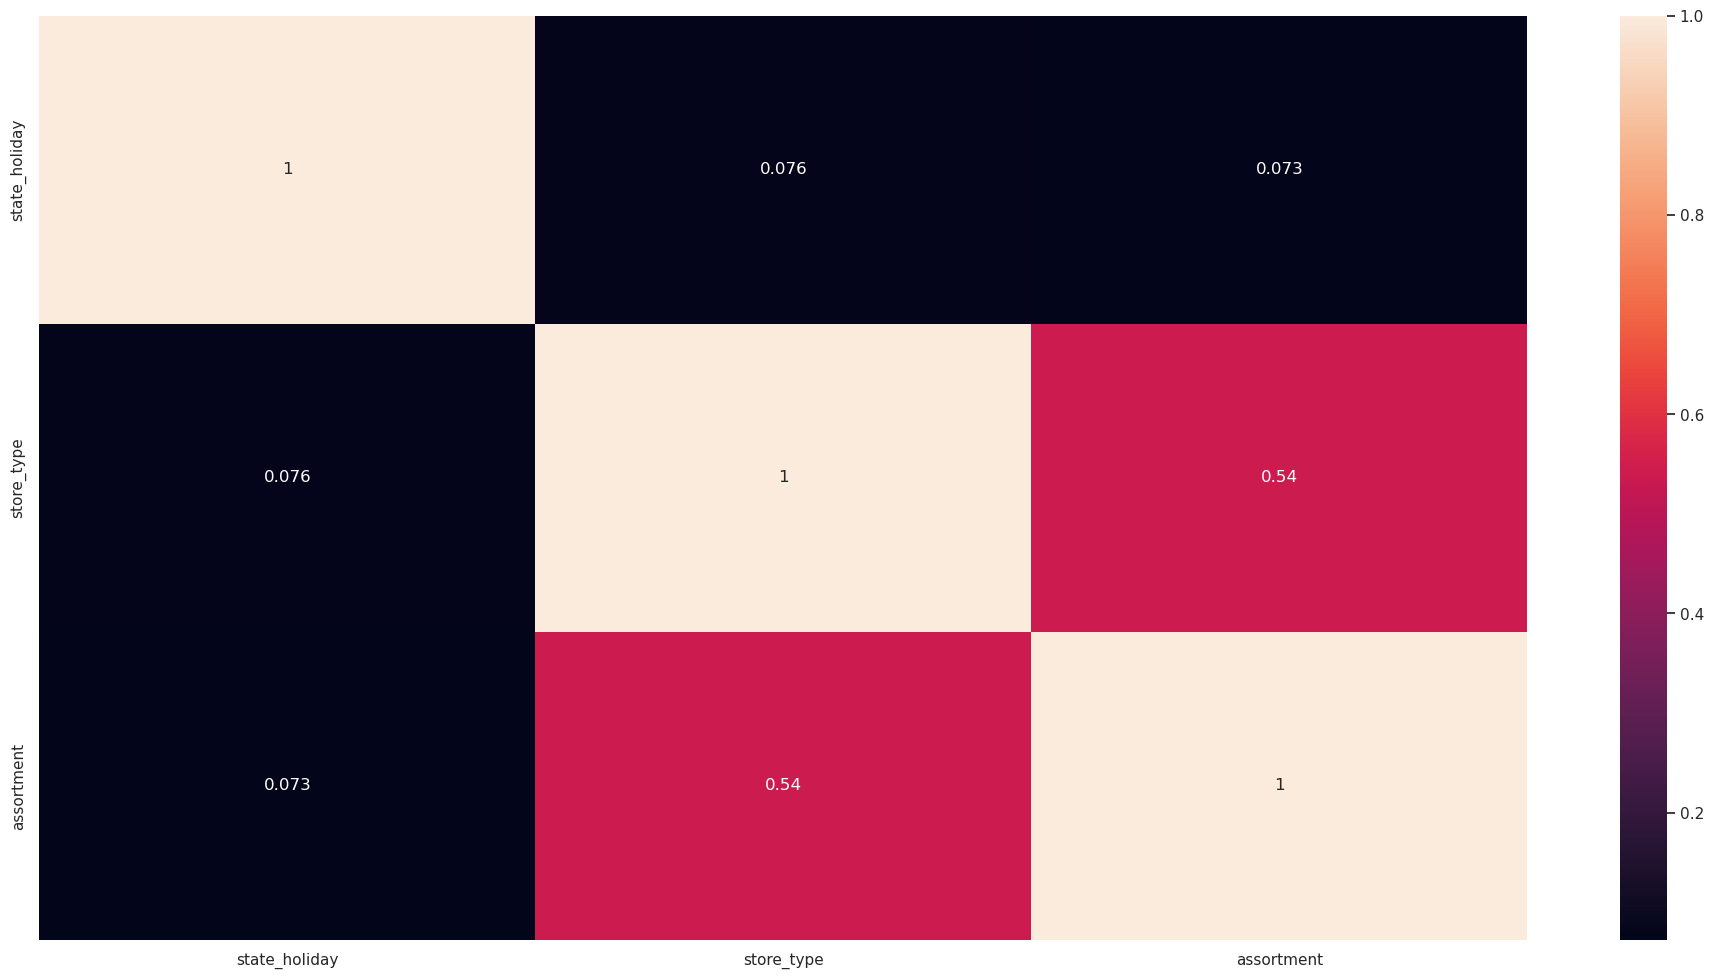

In [59]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0) Preparação dos Dados

In [60]:
df5 = df4.copy()

In [61]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

### 5.1) Normalização

In [62]:
# Não há variáveis independentes com a distribuição normal

### 5.2) Rescaling

In [63]:
mms = MinMaxScaler()
rs = RobustScaler()

# competition_distance -> RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_open_since -> RobustScaler
df5['competition_open_since'] = rs.fit_transform(df5[['competition_open_since']].values)

# competition_duration -> RobustScaler
df5['competition_duration'] = rs.fit_transform(df5[['competition_duration']].values)

# promo2_since -> MinMaxScaler
df5['promo2_since'] = mms.fit_transform(df5[['promo2_since']].values)

# promo_time_week -> MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# week_of_year -> MinMaxScaler
df5['week_of_year'] = mms.fit_transform(df5[['week_of_year']].values)

### 5.3) Transformações

#### 5.3.1) Encoding

In [64]:
ohe = OneHotEncoder()
le = LabelEncoder()

# promo, school_holiday, promo2, is_promo -> OneHot
df5 = pd.get_dummies( df5, prefix=['promo', 'school_holiday', 'promo2', 'is_promo'], columns=['promo', 'school_holiday', 'promo2', 'is_promo'] )

# state_holiday -> Label *
df5['state_holiday'] = le.fit_transform(df5['state_holiday'])

# store_type -> Label *
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

#### 5.3.2) Transformação da variável Target

In [65]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3) Transformação de Natureza

In [66]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6) Seleção de Features

In [67]:
df6 = df5.copy()

In [68]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

### 6.1) Split dos dados em Treino e Test

In [69]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'year_week']
df6 = df6.drop(columns=cols_drop)

In [70]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].min()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-06-19 00:00:00


### 6.2) Seleção de features com Boruta

In [71]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

#### 6.2.1) Best Features from Boruta


In [72]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 6.2) Seleção de features manual

In [83]:
cols_selected_boruta = [
    'store', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2_since_week', 'promo2_since_year',
       'competition_duration',
       'promo2_since', 'promo_time_week', 'promo_False', 'promo_True',
       'school_holiday_False', 'school_holiday_True', 'promo2_False',
       'promo2_True', 'is_promo_False', 'is_promo_True', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'week_of_year_sin', 'week_of_year_cos'
]

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0) Treinamento dos modelos de ML

In [84]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

### 7.1) Modelo Baseline

In [89]:
# predict average
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


### 7.2) Linear Regression

In [90]:
from sklearn.linear_model import LinearRegression

In [91]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1870.64,0.29,2668.60
